### TAHMO Data

In [1]:
!pip install filter_stations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 10.9 MB/s eta 0:00:00


In [44]:
import ee
import pandas as pd
from filter_stations import retreive_data, Filter
import json
import os
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import calendar
import numpy as np
import plotly.express as px

In [2]:
# upload config file
from google.colab import files
uploaded = files.upload()

Saving config.json to config.json


### ToDo: Steps to setting up Google Earth Engine Project

In [14]:
config_path = '/content/config.json'

with open(config_path) as f:
    config = json.load(f)

ee.Authenticate()

# Initialize Google Earth Engine
ee.Initialize(project='ee-kaburiaaustin1')

# authenticate the api
api_key = config['apiKey']
api_secret = config['apiSecret']
maps_key = config['map_api_key']

ret = retreive_data(api_key, api_secret, maps_key)
fs = Filter(api_key, api_secret, maps_key)

# Window for the experiments
start_date='2023-01-01'
end_date='2023-12-31'



### TAHMO Quality flags

In [4]:
# get the quality flags for the stations
variables = ['pr']
dataset = 'controlled'
aggregate = '1d'
csv_file_name = f'KE-2023-01-01-2023-12-31'
quality_flags = True

ke_stations = list(ret.get_stations_info(countrycode='KE').code)

# mult = ret.multiple_measurements(
#     stations_list=ke_stations,
#     startDate=start_date,
#     endDate=end_date,
#     variables=variables,
#     dataset=dataset,
#     aggregate=aggregate,
#     csv_file=csv_file_name,
#     quality_flags=True
# )

# Define the function to get the stations without flags 3 and 4
def q_flag_stations(df, start_date, end_date):
    """
    This function takes a dataframe, start date, and end date and returns the stations that have flags 3 and 4.
    """
    Q_FLAG = df.filter(like='Q_FLAG').columns
    non_na = df[Q_FLAG].loc[start_date: end_date].dropna(axis=1)
    flag_3 = non_na.columns[non_na.isin([3, 3.0]).any()]
    flag_4 = non_na.columns[non_na.isin([4, 4.0]).any()]
    flag_3_4 = set(flag_3).union(set(flag_4))
    return non_na.drop(columns=flag_3_4).columns

# get the stations without flags 3 and 4
def subset_stations(q_flags_df, start_date, end_date):
    """
    This function takes the multiple measurements dataframe, start date, and end date and returns the stations without flags 3 and 4.
    """
    stations = q_flag_stations(q_flags_df, start_date, end_date)
    # remove _Q_FLAG in the station names
    stations = [station.replace('_Q_FLAG', '') for station in stations]
    return stations

def handle_multiple_sensors(df):
    """
    This function takes a DataFrame and returns the stations without multiple sensors.
    If a station has multiple sensors, it returns the one with the highest amount of data.
    """
    # Create a set to store stations that have already been processed
    processed_stations = set()
    interest_cols = []

    # Loop through columns in the dataframe
    for col in df.columns:
        # Split by underscore to identify station and sensor
        station = col.split('_')[0]

        # Check if the station has already been processed
        if station not in processed_stations:
            # Get all columns for the current station
            station_cols = [i for i in df.columns if i.startswith(station)]

            if len(station_cols) > 1:
                # If there are multiple sensors for the station, choose the one with the highest data count
                sensor_col = max(station_cols, key=lambda x: df[x].count())
                interest_cols.append(sensor_col)
            else:
                # If only one sensor exists, just take that column
                interest_cols.append(station_cols[0])

            # Mark the station as processed
            processed_stations.add(station)
        else:
            continue

    # Subset the DataFrame to only the columns of interest
    df = df[interest_cols]

    # Rename the columns to just the station name (remove sensor info)
    df.columns = [i.split('_')[0] for i in df.columns]

    return df

# interest_stations = subset_stations(mult, start_date, end_date)

In [5]:
# Sample stations list
stations = [
    'TA00026',
    'TA00028',
    'TA00029',
    'TA00056',
    'TA00073',
    'TA00074',
    'TA00078',
    'TA00166',
    'TA00172',
    'TA00174',
    'TA00190',
    'TA00196',
    'TA00247',
    'TA00283', # Dedan Kimathi station
    'TA00377',
    'TA00379',
    'TA00386',
    'TA00414',
    'TA00416',
    'TA00444',
    'TA00719'
]

if __name__ == '__main__':
    variables = ['pr']
    start_date = '2023-01-01'
    end_date = '2023-12-31'
    dataset = 'controlled'
    csv_file_name = f'pr-2023-2024'

  # Aggregate presipitation data for 1 day the current default is summming up
    pr_df = ret.multiple_measurements(
        startDate=start_date, endDate=end_date,
        dataset=dataset, stations_list=stations,
        csv_file=csv_file_name, aggregate='1D',
        variables=variables
    )

    # Getting temperature data for the same duration 5min interval
    variables = ['te']
    csv_file_name = f'te-2023-2024'
    te_df = ret.multiple_measurements(
        startDate=start_date, endDate=end_date,
        dataset=dataset, stations_list=stations,
        csv_file=csv_file_name, aggregate='5min',
        variables=variables
    )

    # Aggregate the te_df per day by mean
    print('Aggregating temperature data ---')
    te_df_agg = ret.aggregate_variables(te_df, freq='1D', method='mean')

    # Get the stations metadata
    print('Getting stations metadata ---')
    stations_metadata = ret.get_stations_info(multipleStations=stations)

    # Get the stations info for kenya
    print('Getting stations metadata for kenya ---')
    stations_ke = ret.get_stations_info(countrycode='KE')

    # Get the available variables
    print('Getting available variables ---')
    we_vars = ret.get_variables()



Retrieving data for stations:   0%|          | 0/21 [00:00<?, ?it/s]

Retrieving data for stations:   0%|          | 0/21 [00:00<?, ?it/s]

Aggregating temperature data ---
Getting stations metadata ---
Getting stations metadata for kenya ---
Getting available variables ---


### TAHMO variables
wg : wind gusts <br>
ws : wind speed <br>
wd : wind direction <br>
pr : precipitation<br>
te : surface level temperature<br>


In [9]:
ret.get_variables()

{'ap': {'id': 1,
  'name': 'atmosphericpressure',
  'description': 'Atmospheric pressure',
  'shortcode': 'ap',
  'units': 'kPa',
  'creatorid': 1,
  'created': '2018-10-25T14:12:08.669234Z',
  'updaterid': 1,
  'updated': '2018-10-25T14:12:08.669234Z'},
 'dw': {'id': 3,
  'name': 'waterdepth',
  'description': 'Depth of water',
  'shortcode': 'dw',
  'units': 'mm',
  'creatorid': 1,
  'created': '2018-10-25T14:12:08.732335Z',
  'updaterid': 1,
  'updated': '2018-10-25T14:12:08.732335Z'},
 'ec': {'id': 4,
  'name': 'electricalconductivity',
  'description': 'Electrical conductivity of precipitation',
  'shortcode': 'ec',
  'units': 'mS/cm',
  'creatorid': 1,
  'created': '2018-10-25T14:12:08.763033Z',
  'updaterid': 1,
  'updated': '2018-10-25T14:12:08.763033Z'},
 'ew': {'id': 5,
  'name': 'waterelectricalconductivity',
  'description': 'Electrical conductivity of water',
  'shortcode': 'ew',
  'units': 'mS/cm',
  'creatorid': 1,
  'created': '2018-10-25T14:12:08.793802Z',
  'updaterid

### CHIRPS
Daily precipitation values

In [6]:
# Method to extract rainfall data at a specific point for each date in the time range
def extract_rainfall_series(lat, lon, start_date, end_date, range_roi=[36.0, -1.0, 37.0, 1.0]):
    '''
    lat - latitude
    lon - longitude
    start_date - start date in format 'YYYY-MM-DD'
    end_date - end date in format 'YYYY-MM-DD'
    range_roi - range of roi to extract rainfall data (The bounding box)
    '''

    # Define a region of interest (bounding box)
    roi = ee.Geometry.Rectangle(range_roi)  # Coordinates for an example region in Kenya
    # Add one day to the last day
    end_date = pd.to_datetime(end_date) + pd.Timedelta(days=1)
    end_date = end_date.strftime('%Y-%m-%d')

    # Load CHIRPS dataset
    chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
                .filterDate(f'{start_date}', f'{end_date}') \
                .filterBounds(roi)
    point = ee.Geometry.Point(lon, lat)  # Define the point from latitude and longitude

    # Map function to extract rainfall for each day and create a time series
    def extract_rainfall(image):
        # Get the date for the image (e.g., "YYYY-MM-DD")
        date = image.get('system:time_start')
        # Extract the rainfall value at the point for that date
        value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=5000
        ).get('precipitation')  # 'precipitation' is the band name for CHIRPS

        return ee.Feature(None, {
            'date': ee.Date(date).format('YYYY-MM-dd'),
            'rainfall': value
        })

    # Apply the function to each image in the collection
    rainfall_series = chirps.map(extract_rainfall)

    # Convert the FeatureCollection to a list of features
    features = rainfall_series.getInfo()['features']

    # Convert to pandas DataFrame
    data = [{'Date': f['properties']['date'], 'rainfall': f['properties']['rainfall']} for f in features]
    df = pd.DataFrame(data)

    # Ensure 'date' is a datetime object
    df['Date'] = pd.to_datetime(df['Date'])

    return df

# Example: Extract rainfall data for a specific point (latitude, longitude)
lat, lon = -0.287122, 36.169981  # Example coordinates
rainfall_df = extract_rainfall_series(lat, lon, start_date='2023-01-01', end_date='2023-12-31')


# Print the DataFrame containing the rainfall time series
rainfall_df


Date  rainfall
0   2023-01-01   0.00000
1   2023-01-02   0.00000
2   2023-01-03   0.00000
3   2023-01-04   0.00000
4   2023-01-05   0.00000
..         ...       ...
360 2023-12-27   0.00000
361 2023-12-28   0.00000
362 2023-12-29   0.00000
363 2023-12-30   0.00000
364 2023-12-31   5.97122

[365 rows x 2 columns]

In [7]:
# given the station name to get the coordinates (lat,lon)
def get_station_coords(station_name, metadata=stations_metadata):
  lat, lon = stations_metadata[stations_metadata['code'] == station_name][['location.latitude',
                                                                           'location.longitude']].values[0]
  return lat, lon

print(get_station_coords('TA00026'))

# rename the columns from chirps with the station name during extraction as the station name
def extract_with_station_name(station_name, start_date, end_date, metadata=stations_metadata,
                              range_roi=[36.0, -1.0, 37.0, 1.0], data='CHIRPS'):
  '''
  data - CHIRPS or ERA5
  '''
  # extract the data
  df = extract_rainfall_series(lat=get_station_coords(station_name, metadata=metadata)[0],
                               lon=get_station_coords(station_name, metadata=metadata)[1],
                               start_date=start_date, end_date=end_date,
                               range_roi=range_roi)
  # Rename the rainfall column to station_name
  df.rename(columns={'rainfall': station_name}, inplace=True)
  # set the Date as the index
  df.set_index('Date', inplace=True)
  return df

# Create one dataframe from the tahmo stations
station_name_list = stations_metadata['code'].tolist()

def create_df_from_stations(station_name_list, start_date, end_date, metadata=stations_metadata, range_roi=[36.0, -1.0, 37.0, 1.0]):
  df_list = []
  for station_name in station_name_list:
    df_list.append(extract_with_station_name(station_name, start_date, end_date, metadata=metadata, range_roi=range_roi))
  return pd.concat(df_list, axis=1)

chirps_tahmo_ke = create_df_from_stations(station_name_list, start_date='2023-01-01', end_date='2023-12-31')



(-0.2871222, 36.1699806)


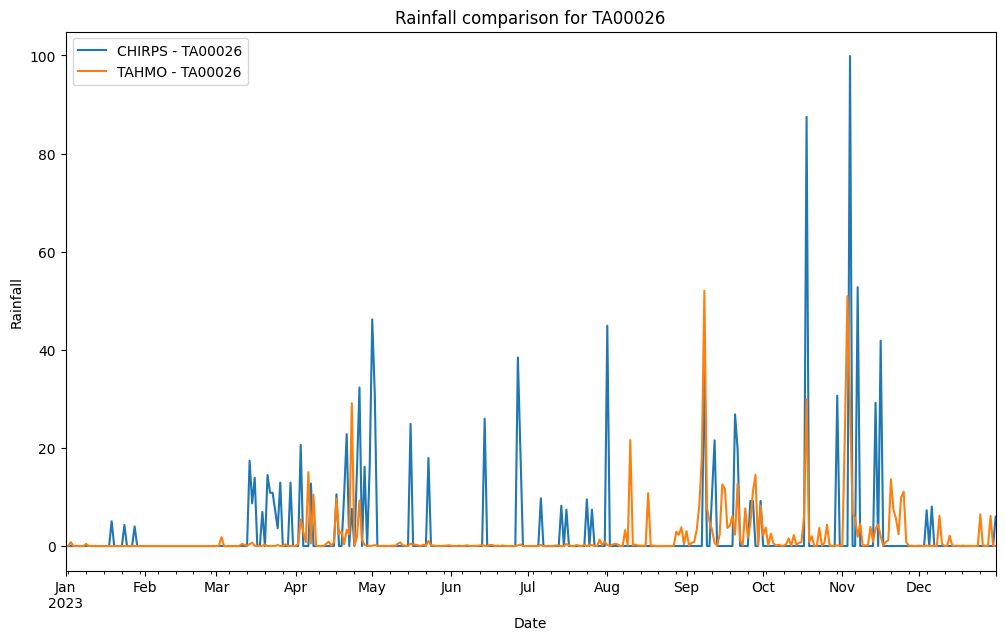

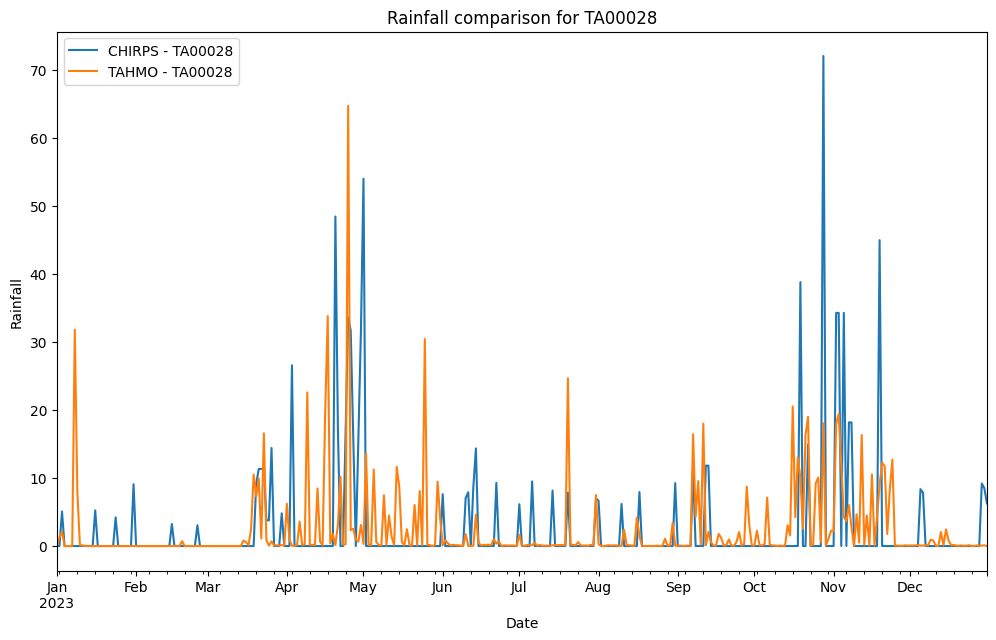

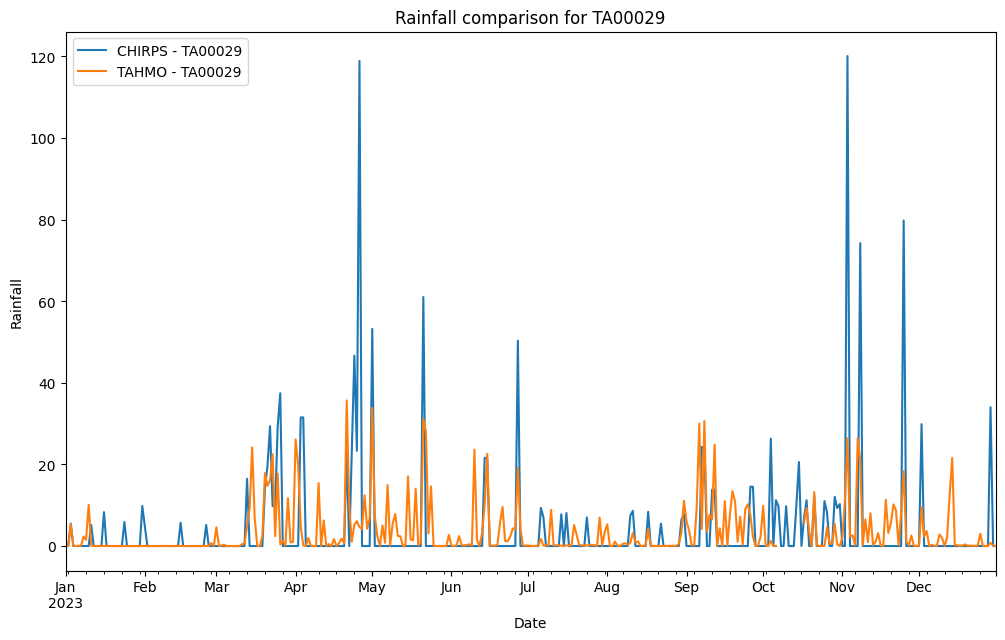

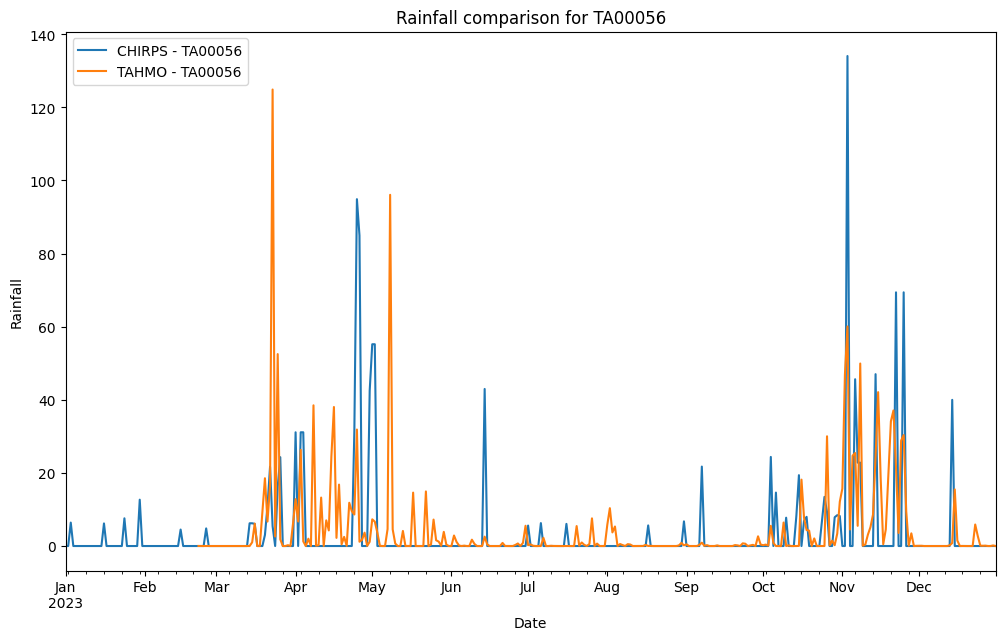

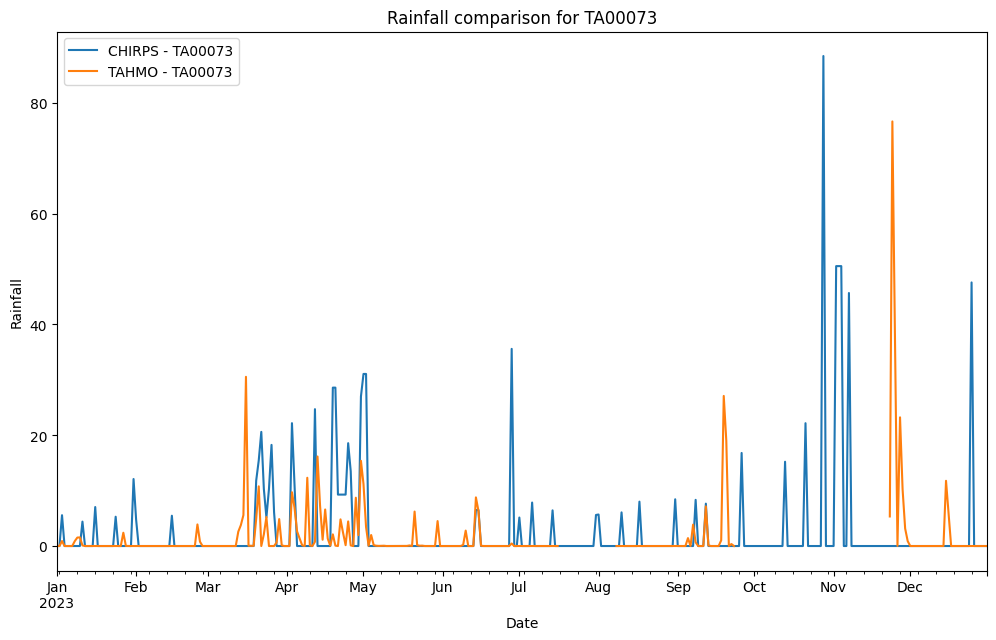

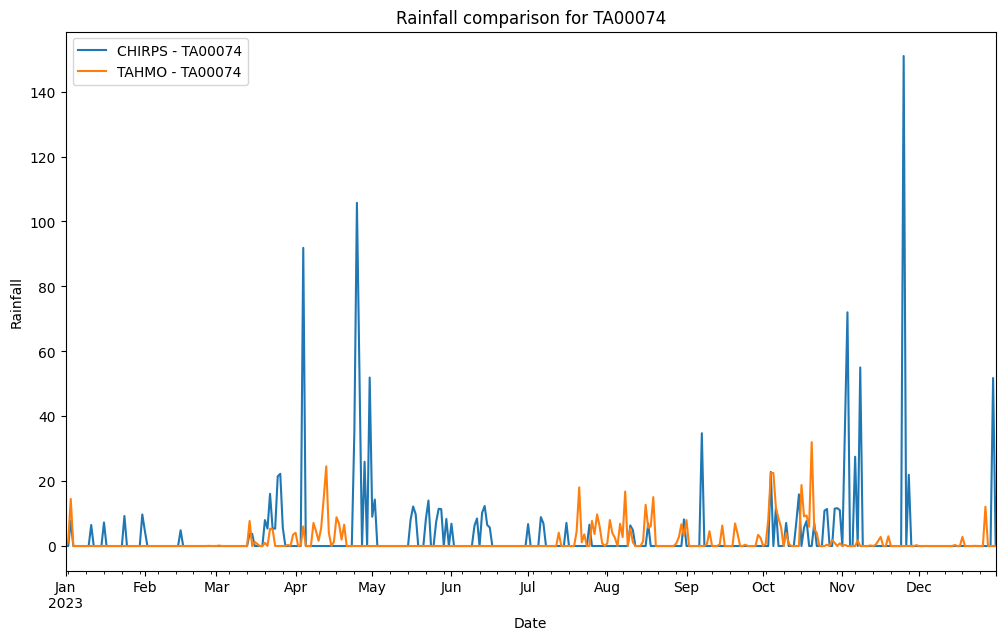

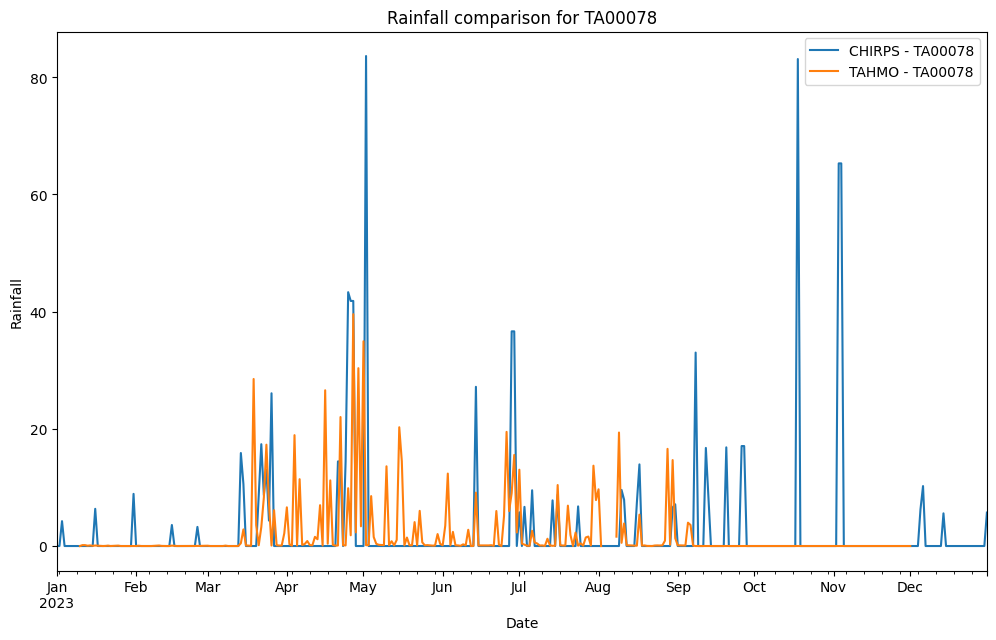

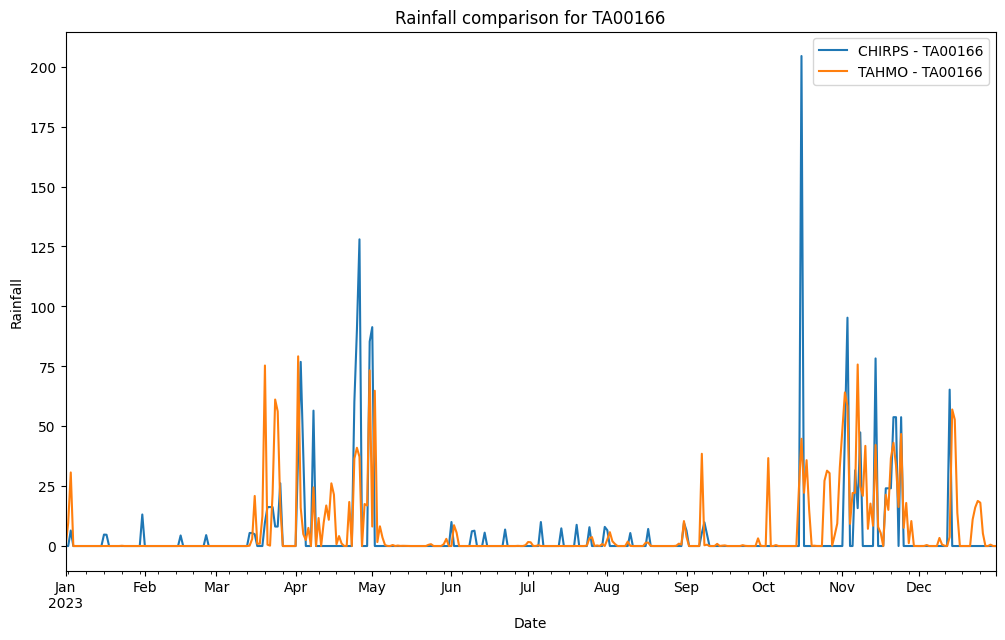

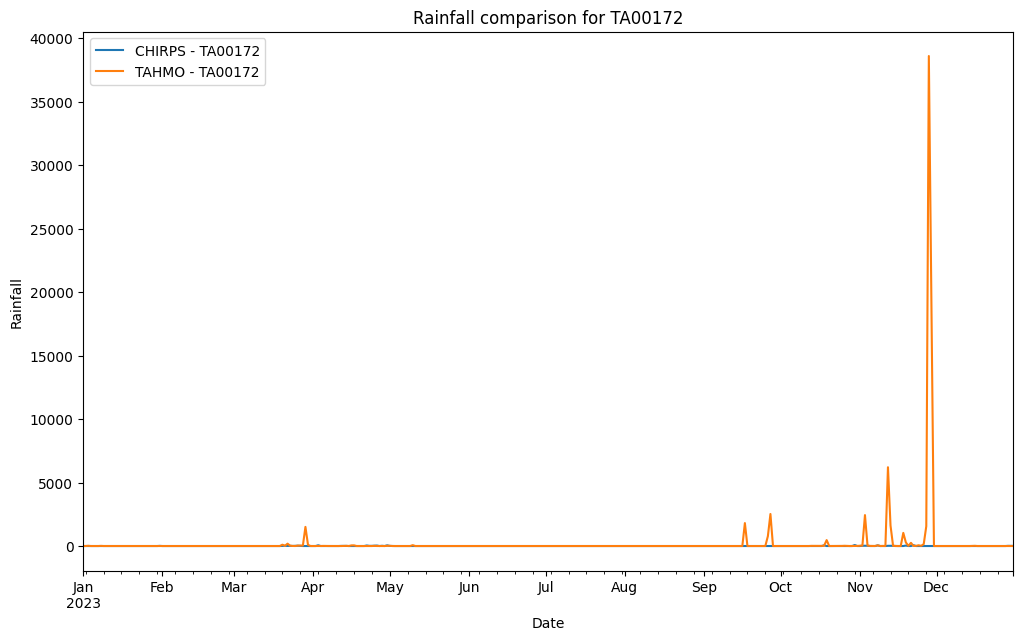

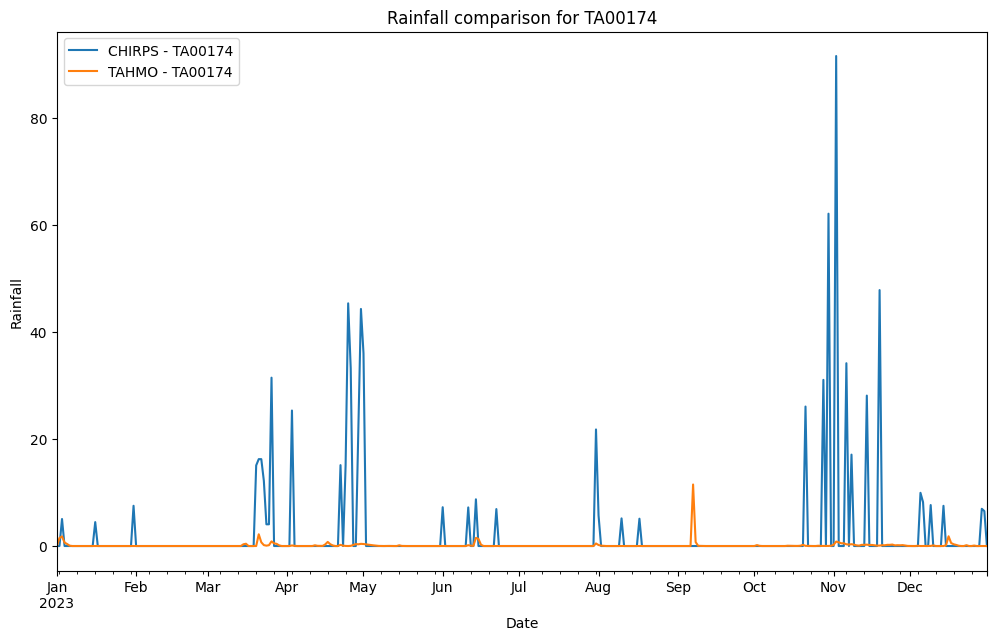

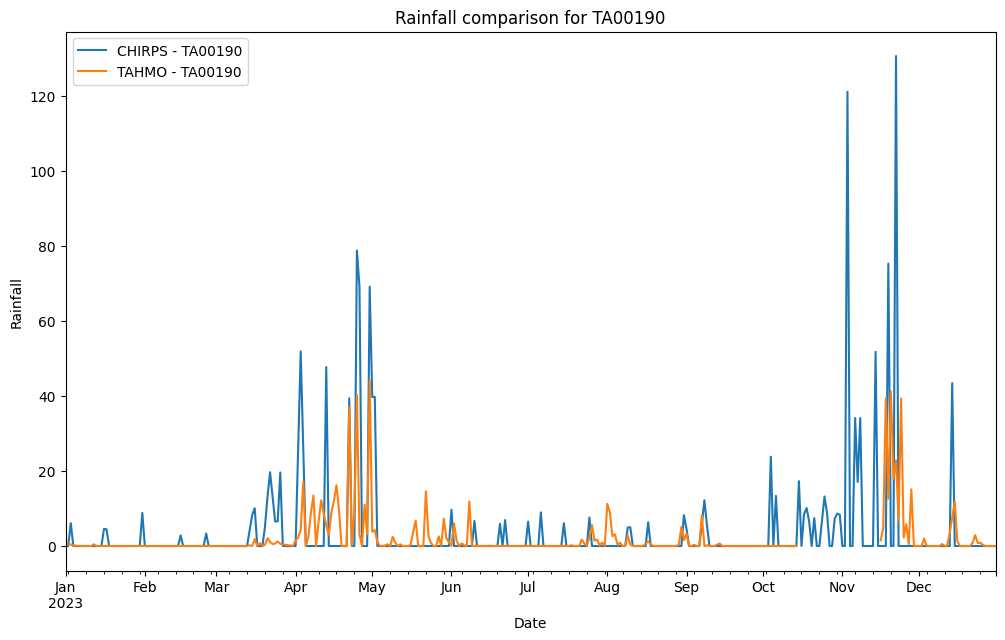

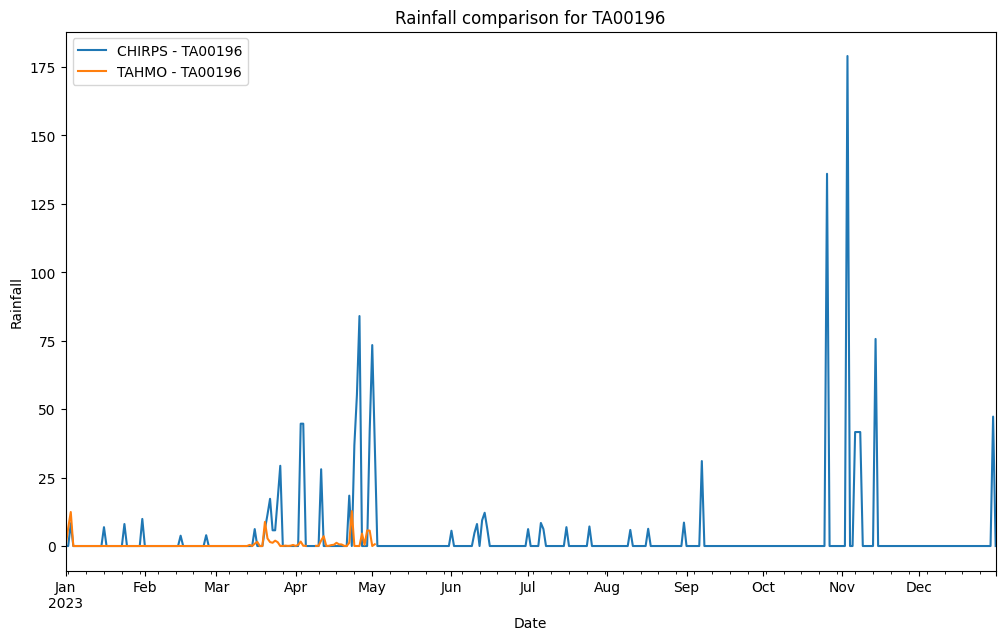

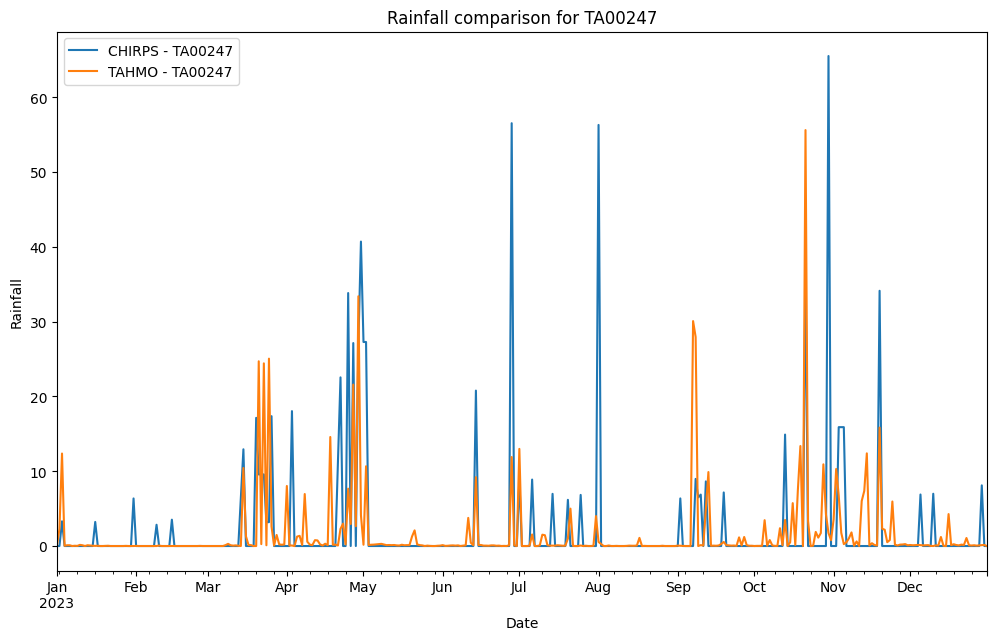

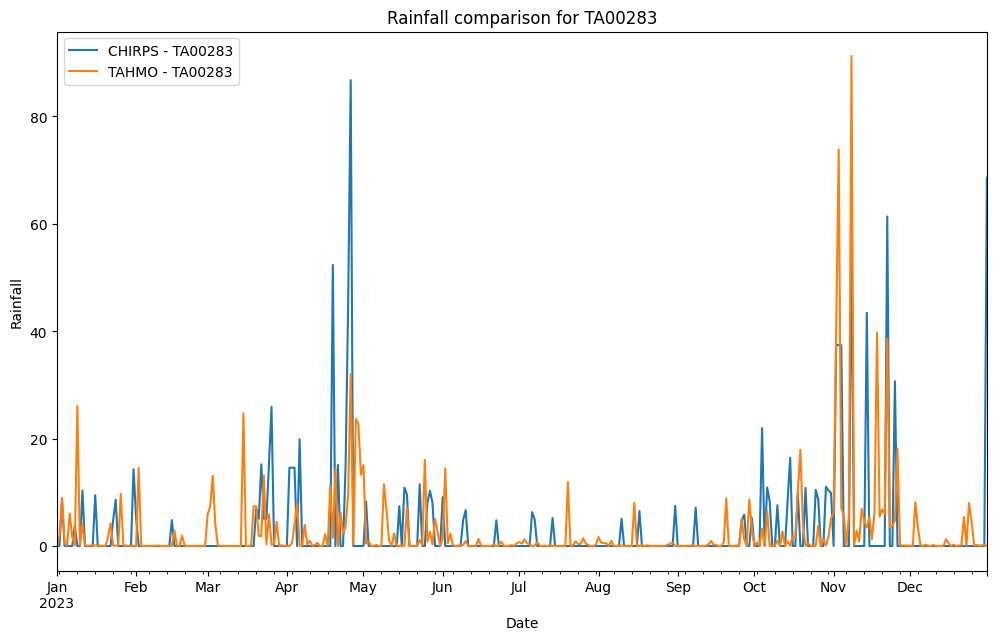

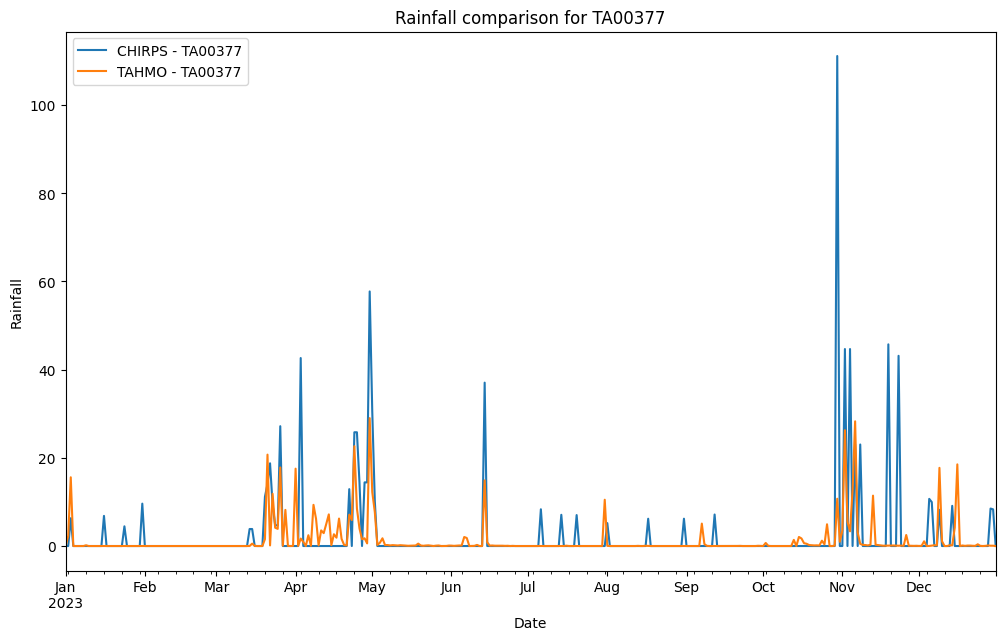

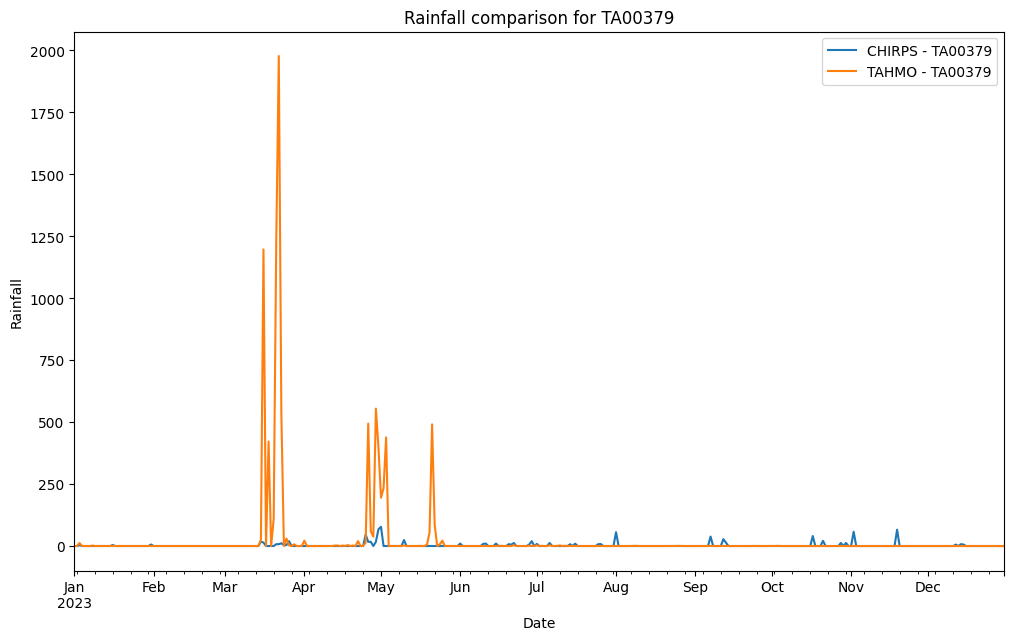

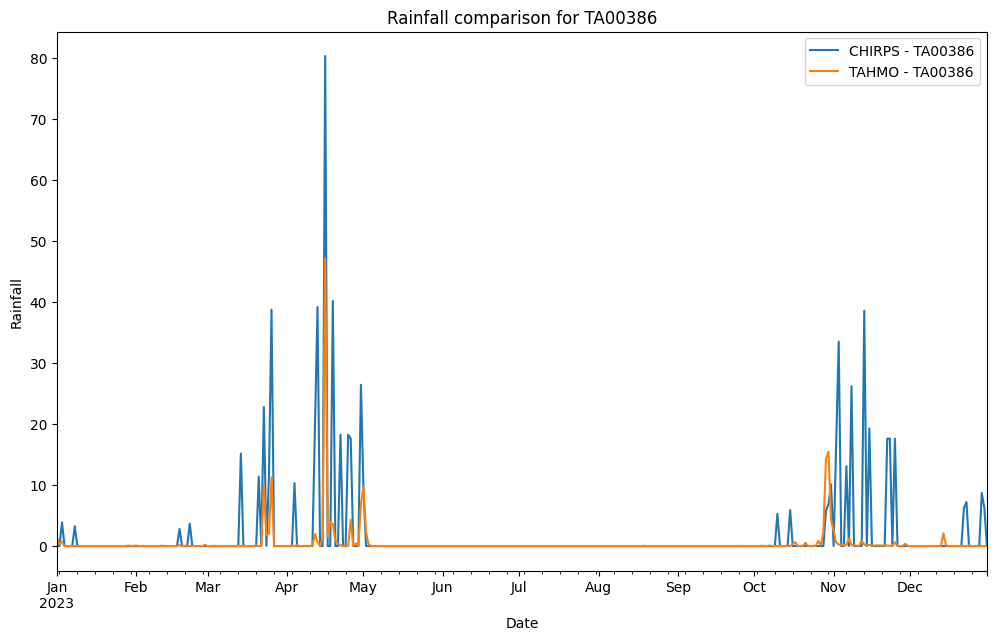

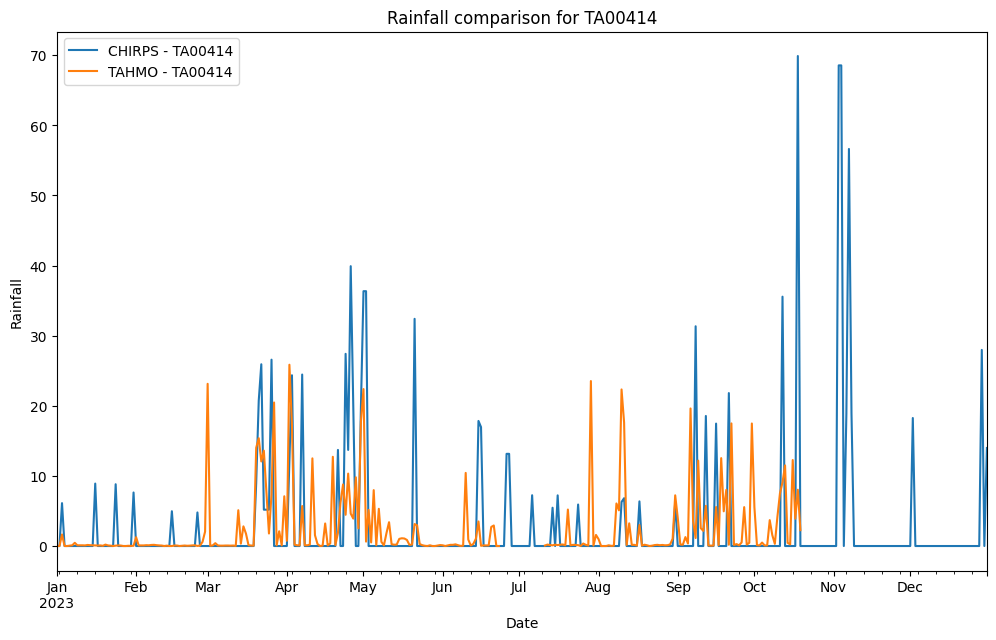

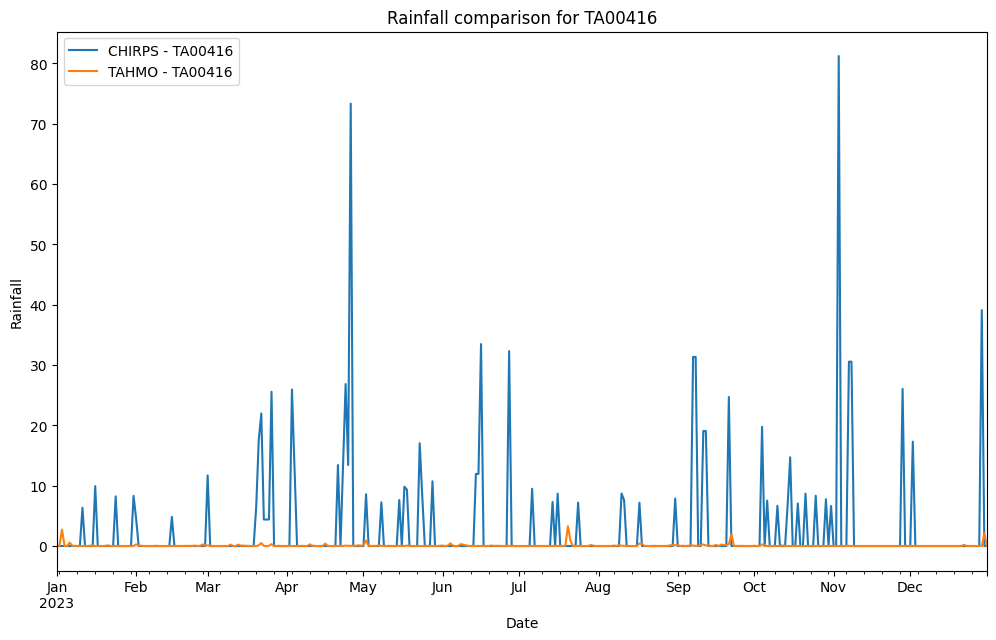

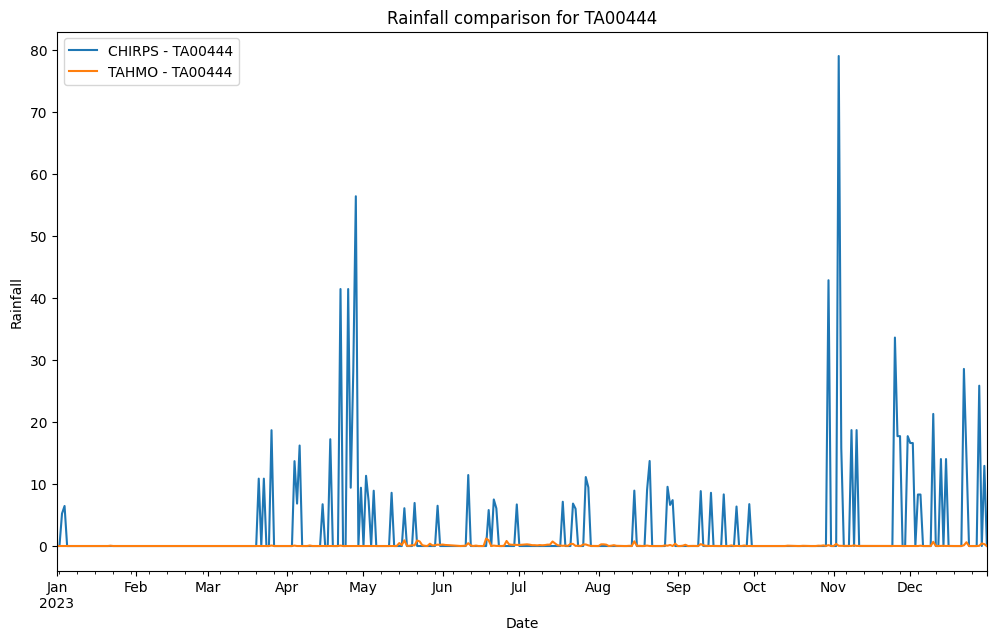

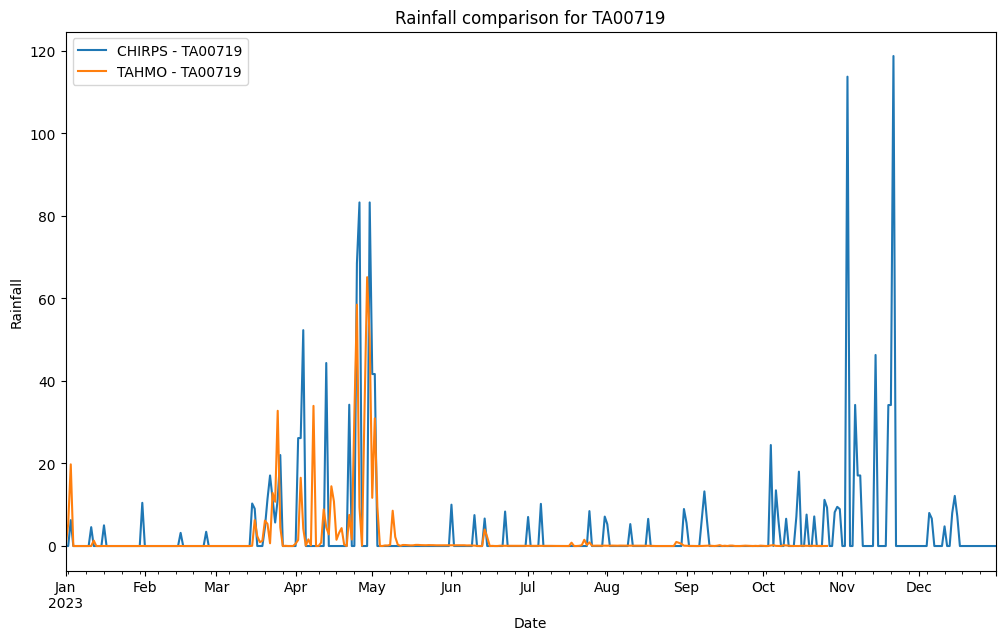

In [10]:
# plt.figure(figsize=(20,10))
for station_name in station_name_list:
  chirps_tahmo_ke[station_name].plot(figsize=(12,7), label=f'CHIRPS - {station_name}') # Added label
  # plt.legend(station_name)
  pr_df[station_name].plot(figsize=(12,7), label=f'TAHMO - {station_name}') # Added label
  # plt.legend(station_name)
  plt.legend() # Show the legend
  plt.xlabel("Date") # x axis label
  plt.ylabel("Rainfall") # y axis label
  plt.title(f"Rainfall comparison for {station_name}") # add title
  plt.show()

### ERA5

- Spatial Resolution: 0.25° × 0.25° (~31 km at the equator).
- Temporal Resolution: Hourly data.
- Variables: ERA5 provides a wide range of meteorological variables, such as temperature, precipitation, wind components, humidity, and pressure.

In [11]:
def create_monthly_chunks(start_date, end_date):
    """
    Create a list of monthly temporal chunks between start_date and end_date.

    Args:
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.

    Returns:
        list: A list of tuples, where each tuple contains the start and end date of a month.
    """
    # Convert start and end dates to datetime objects
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')

    # Initialize an empty list to store the chunks
    chunks = []

    # Generate chunks month by month
    current = start
    while current <= end:
        # Get the last day of the current month
        last_day_of_month = calendar.monthrange(current.year, current.month)[1]

        # Define the start and end date for the chunk
        chunk_start = current.strftime('%Y-%m-%d')
        chunk_end = datetime(current.year, current.month, last_day_of_month).strftime('%Y-%m-%d')

        # Ensure the chunk end does not exceed the global end date
        if datetime.strptime(chunk_end, '%Y-%m-%d') > end:
            chunk_end = end.strftime('%Y-%m-%d')

        # Append the chunk to the list
        chunks.append((chunk_start, chunk_end))

        # Move to the first day of the next month
        current = (current + timedelta(days=last_day_of_month)).replace(day=1)

    return chunks

start_date = '2023-01-01'
end_date = '2023-12-31'
temporal_chunks = create_monthly_chunks(start_date, end_date)
temporal_chunks


[('2023-01-01', '2023-01-31'),
 ('2023-02-01', '2023-02-28'),
 ('2023-03-01', '2023-03-31'),
 ('2023-04-01', '2023-04-30'),
 ('2023-05-01', '2023-05-31'),
 ('2023-06-01', '2023-06-30'),
 ('2023-07-01', '2023-07-31'),
 ('2023-08-01', '2023-08-31'),
 ('2023-09-01', '2023-09-30'),
 ('2023-10-01', '2023-10-31'),
 ('2023-11-01', '2023-11-30'),
 ('2023-12-01', '2023-12-31')]

In [17]:
# Function to extract ERA5 data for a given point and time range
def extract_era5_hourly_series(lat, lon, start_date, end_date,
                               range_roi=[36.0, -1.0, 37.0, 1.0],
                               variable='total_precipitation'):
    # Add one day to the last day
    end_date = pd.to_datetime(end_date) + pd.Timedelta(days=1)
    end_date = end_date.strftime('%Y-%m-%d')

    roi = ee.Geometry.Rectangle(range_roi)   # coordinates in Kenya

    era5_hourly = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
                .filterBounds(roi) \
                .select(variable)  # Precipitation band
    point = ee.Geometry.Point(lon, lat)

    # Filter the dataset by date range
    era5_hourly_chunk = era5_hourly.filterDate(start_date, end_date)

    def extract_rainfall(image):
        # Get date and time of the image
        date = image.get('system:time_start')
        # Extract precipitation value at the point
        value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=5000
        ).get('total_precipitation')
        return ee.Feature(None, {
            'datetime': ee.Date(date).format('YYYY-MM-dd HH:mm:ss'),
            'rainfall': value
        })

    # Apply extraction function to each image in the chunk
    rainfall_series = era5_hourly_chunk.map(extract_rainfall)
    features = rainfall_series.getInfo()['features']

    # Create a DataFrame from the features
    data = [{'Date': f['properties']['datetime'], 'Rainfall': f['properties']['rainfall']} for f in features]
    return pd.DataFrame(data)

# Method to get the data from the lat,lon provided
def get_era5_data(lat, lon, start_date, end_date,
                  variable='total_precipitation',
                  range_roi=[36.0, -1.0, 37.0, 1.0]):
  # get the temporal chunks
  temporal_chunks = create_monthly_chunks(start_date, end_date)
  era5_df = pd.DataFrame()

  # Loop through each temporal chunk and append the results to the complete DataFrame
  for start_date, end_date in temporal_chunks:
      print(f"Processing data from {start_date} to {end_date}...")
      chunk_df = extract_era5_hourly_series(lat, lon, start_date, end_date)
      era5_df = pd.concat([era5_df, chunk_df], ignore_index=True)

  # Ensure 'Date' column is in datetime format
  era5_df['Date'] = pd.to_datetime(era5_df['Date'])

  # set Date as index
  era5_df.set_index('Date', inplace=True)

  return era5_df


era5_df = get_era5_data(lat=-0.287122, lon=36.169981, start_date='2023-01-01', end_date='2023-12-31',
                        variable=['total_precipitation', 'u10', 'v10', 'temperature_2m', '10fg'])
era5_df

Processing data from 2023-01-01 to 2023-01-31...
Processing data from 2023-02-01 to 2023-02-28...
Processing data from 2023-03-01 to 2023-03-31...
Processing data from 2023-04-01 to 2023-04-30...
Processing data from 2023-05-01 to 2023-05-31...
Processing data from 2023-06-01 to 2023-06-30...
Processing data from 2023-07-01 to 2023-07-31...
Processing data from 2023-08-01 to 2023-08-31...
Processing data from 2023-09-01 to 2023-09-30...
Processing data from 2023-10-01 to 2023-10-31...
Processing data from 2023-11-01 to 2023-11-30...
Processing data from 2023-12-01 to 2023-12-31...


Rainfall
Date                             
2023-01-01 00:00:00  1.734723e-18
2023-01-01 01:00:00  0.000000e+00
2023-01-01 02:00:00  3.469447e-18
2023-01-01 03:00:00 -3.469447e-18
2023-01-01 04:00:00  0.000000e+00
...                           ...
2023-12-31 19:00:00  1.222038e-05
2023-12-31 20:00:00  2.264594e-05
2023-12-31 21:00:00  2.655718e-05
2023-12-31 22:00:00 -1.734723e-18
2023-12-31 23:00:00  1.160728e-05

[8760 rows x 1 columns]

In [19]:
# Function to extract ERA5 data for a given point, time range, and variables
def extract_era5_hourly_series(lat, lon, start_date, end_date,
                               range_roi=[36.0, -1.0, 37.0, 1.0],
                               variables=['total_precipitation']):
    # Add one day to the last day
    end_date = pd.to_datetime(end_date) + pd.Timedelta(days=1)
    end_date = end_date.strftime('%Y-%m-%d')

    roi = ee.Geometry.Rectangle(range_roi)   # Region of interest (ROI)

    point = ee.Geometry.Point(lon, lat)

    # Initialize an empty dictionary to hold data for each variable
    data = []

    for variable in variables:
        era5_hourly = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
                    .filterBounds(roi) \
                    .select(variable)  # Select the variable band

        # Filter the dataset by date range
        era5_hourly_chunk = era5_hourly.filterDate(start_date, end_date)

        def extract_variable(image):
            # Get date and time of the image
            date = image.get('system:time_start')
            # Extract the variable value at the point
            value = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=point,
                scale=5000
            ).get(variable)
            return ee.Feature(None, {
                'datetime': ee.Date(date).format('YYYY-MM-dd HH:mm:ss'),
                variable: value
            })

        # Apply extraction function to each image in the chunk
        variable_series = era5_hourly_chunk.map(extract_variable)
        features = variable_series.getInfo()['features']

        # Convert features into a DataFrame
        variable_data = [{'Date': f['properties']['datetime'], variable: f['properties'][variable]} for f in features]
        data.append(pd.DataFrame(variable_data))

    # Merge data for all variables
    result_df = data[0]
    for df in data[1:]:
        result_df = result_df.merge(df, on='Date', how='outer')

    return result_df

# Method to get the data from the lat, lon provided for multiple variables
def get_era5_data(lat, lon, start_date, end_date,
                  variables=['total_precipitation'],
                  range_roi=[36.0, -1.0, 37.0, 1.0]):
    # Define temporal chunks (monthly)
    temporal_chunks = create_monthly_chunks(start_date, end_date)
    era5_df = pd.DataFrame()

    # Loop through each temporal chunk and append the results to the complete DataFrame
    for start, end in temporal_chunks:
        print(f"Processing data from {start} to {end}...")
        chunk_df = extract_era5_hourly_series(lat, lon, start, end,
                                              range_roi=range_roi,
                                              variables=variables)
        era5_df = pd.concat([era5_df, chunk_df], ignore_index=True)

    # Ensure 'Date' column is in datetime format
    era5_df['Date'] = pd.to_datetime(era5_df['Date'])

    # Set Date as index
    era5_df.set_index('Date', inplace=True)

    return era5_df

# Example usage
era5_df = get_era5_data(
    lat=-0.287122,
    lon=36.169981,
    start_date='2023-01-01',
    end_date='2023-12-31',
    variables=['total_precipitation',
               'u_component_of_wind_10m',
               'v_component_of_wind_10m',
               'temperature_2m',
               'instantaneous_10m_wind_gust']
)
era5_df


Processing data from 2023-01-01 to 2023-01-31...
Processing data from 2023-02-01 to 2023-02-28...
Processing data from 2023-03-01 to 2023-03-31...
Processing data from 2023-04-01 to 2023-04-30...
Processing data from 2023-05-01 to 2023-05-31...
Processing data from 2023-06-01 to 2023-06-30...
Processing data from 2023-07-01 to 2023-07-31...
Processing data from 2023-08-01 to 2023-08-31...
Processing data from 2023-09-01 to 2023-09-30...
Processing data from 2023-10-01 to 2023-10-31...
Processing data from 2023-11-01 to 2023-11-30...
Processing data from 2023-12-01 to 2023-12-31...
                     total_precipitation  u_component_of_wind_10m  \
Date                                                                
2023-01-01 00:00:00         1.734723e-18                 0.997077   
2023-01-01 01:00:00         0.000000e+00                 0.965426   
2023-01-01 02:00:00         3.469447e-18                 1.154063   
2023-01-01 03:00:00        -3.469447e-18                 1.137716  

In [51]:
era5_df['temperature_2m'] = era5_df['temperature_2m'] -273.15
era5_df['total_precipitation'] = era5_df['total_precipitation'] * 1000

In [30]:
def calculate_wind(df):
  # Calculate wind speed
  df['wind_speed'] = np.sqrt(df['u_component_of_wind_10m']**2 + df['v_component_of_wind_10m']**2)

  # Calculate wind direction in degrees
  df['wind_direction'] = np.arctan2(df['u_component_of_wind_10m'], df['v_component_of_wind_10m']) * 180 / np.pi
  df['wind_direction'] = (df['wind_direction'] + 360) % 360  # Ensure direction is between 0 and 360

  return df

era5_df = calculate_wind(era5_df)

In [34]:
era5_df

total_precipitation  u_component_of_wind_10m  \
Date                                                                
2023-01-01 00:00:00         1.734723e-18                 0.997077   
2023-01-01 01:00:00         0.000000e+00                 0.965426   
2023-01-01 02:00:00         3.469447e-18                 1.154063   
2023-01-01 03:00:00        -3.469447e-18                 1.137716   
2023-01-01 04:00:00         0.000000e+00                 1.091854   
...                                  ...                      ...   
2023-12-31 19:00:00         1.222038e-05                 0.795232   
2023-12-31 20:00:00         2.264594e-05                 0.721649   
2023-12-31 21:00:00         2.655718e-05                 1.046072   
2023-12-31 22:00:00        -1.734723e-18                 1.045843   
2023-12-31 23:00:00         1.160728e-05                 0.953755   

                     v_component_of_wind_10m  temperature_2m  \
Date                                                           
2023-01-01 00:00:00                -0.749381       23.798203   
2023-01-01 01:00:00                -0.235556       23.734960   
2023-01-01 02:00:00                 0.241521       23.635694   
2023-01-01 03:00:00                 0.695199       23.626172   
2023-01-01 04:00:00                 0.992551       23.595879   
...                                      ...             ...   
2023-12-31 19:00:00                -1.383193       24.312767   
2023-12-31 20:00:00                -2.377337       24.282382   
2023-12-31 21:00:00                -2.706118       24.320312   
2023-12-31 22:00:00                -1.912939       24.233991   
2023-12-31 23:00:00                -1.472513       24.213661   

                     instantaneous_10m_wind_gust  wind_speed  wind_direction  
Date                                                                          
2023-01-01 00:00:00                     2.906749    1.247291      126.927744  
2023-01-01 01:00:00                     2.839849    0.993747      103.711814  
2023-01-01 02:00:00                     2.778281    1.179065       78.179813  
2023-01-01 03:00:00                     2.740005    1.333304       58.573069  
2023-01-01 04:00:00                     3.079238    1.475569       47.727563  
...                                          ...         ...             ...  
2023-12-31 19:00:00                     4.203612    1.595499      150.104347  
2023-12-31 20:00:00                     7.064889    2.484453      163.114157  
2023-12-31 21:00:00                     7.198491    2.901265      158.865579  
2023-12-31 22:00:00                     6.010680    2.180166      151.333661  
2023-12-31 23:00:00                     4.085247    1.754407      147.068635  

[8760 rows x 7 columns]

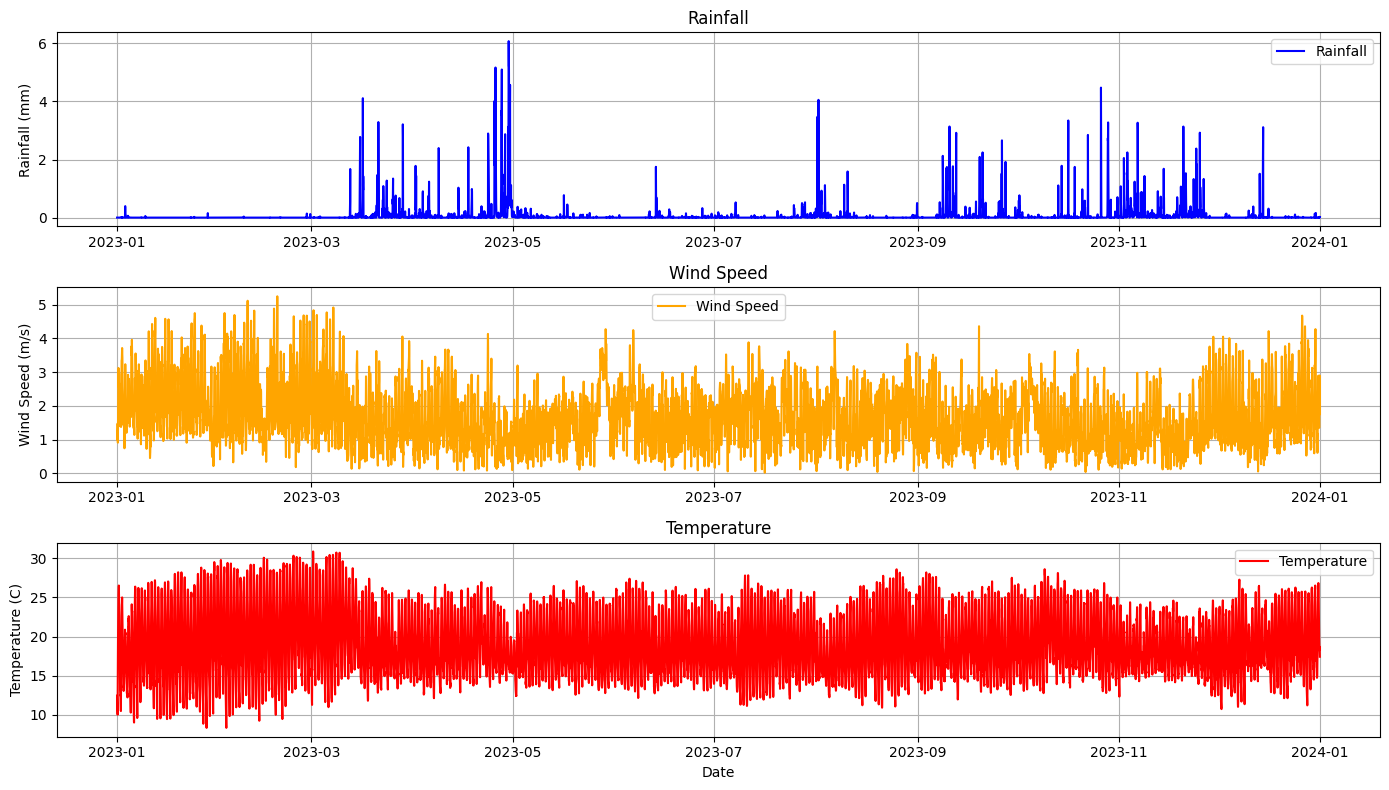

In [55]:
# Step 2: Plot the data
plt.figure(figsize=(14, 8))

# Rainfall Plot
plt.subplot(3, 1, 1)
plt.plot(era5_df.index, era5_df['total_precipitation'], color='blue', label='Rainfall')
plt.title('Rainfall')
plt.ylabel('Rainfall (mm)')
plt.grid()
plt.legend()

# Wind Speed Plot
plt.subplot(3, 1, 2)
plt.plot(era5_df.index, era5_df['wind_speed'], color='orange', label='Wind Speed')
plt.title('Wind Speed')
plt.ylabel('Wind Speed (m/s)')
plt.grid()
plt.legend()

# Temperature Plot
plt.subplot(3, 1, 3)
plt.plot(era5_df.index, era5_df['temperature_2m'], color='red', label='Temperature')
plt.title('Temperature')
plt.ylabel('Temperature (C)')
plt.xlabel('Date')
plt.grid()
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [64]:
# Rainfall
fig = px.line(era5_df, x=era5_df.index, y='total_precipitation', title='Rainfall Time Series')
fig.show()

# Wind Speed
fig = px.line(era5_df, x=era5_df.index, y='wind_speed', title='Wind Speed Time Series')
fig.show()

# Temperature
fig = px.line(era5_df, x=era5_df.index, y='temperature_2m', title='Temperature Time Series')
fig.show()


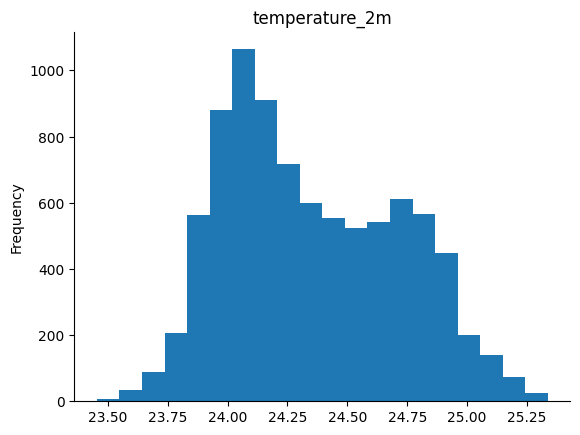

In [38]:
# @title temperature_2m

from matplotlib import pyplot as plt
era5_df['temperature_2m'].plot(kind='hist', bins=20, title='temperature_2m')
plt.gca().spines[['top', 'right',]].set_visible(False)

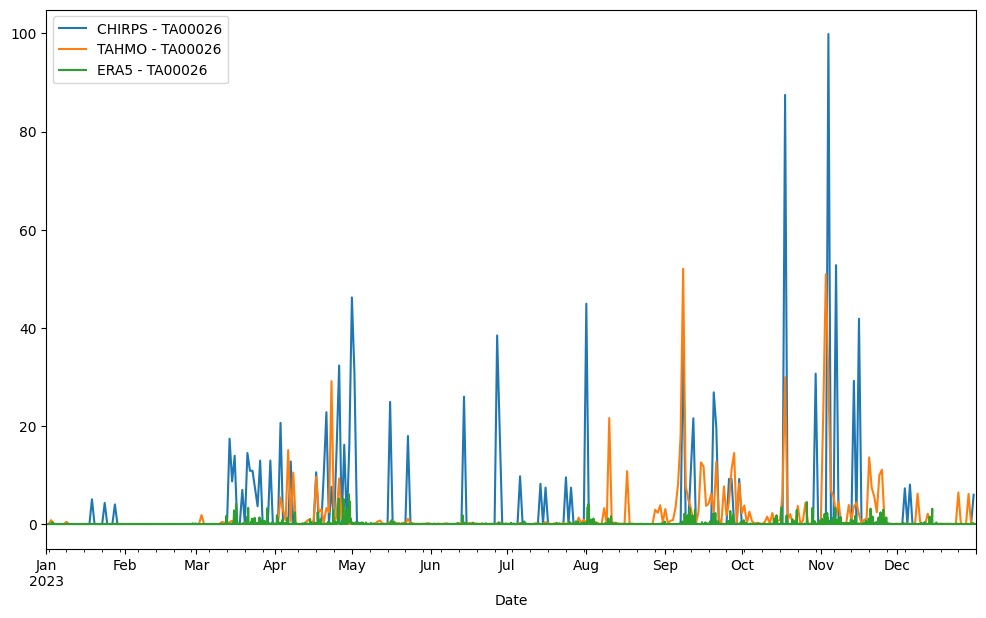

In [74]:
# rainfall_df.plot(x='Date', y='rainfall')
chirps_tahmo_ke[station_name_list[0]].plot(figsize=(12,7), label=f'CHIRPS - {station_name_list[0]}') # Added label
  # plt.legend(station_name)
pr_df[station_name_list[0]].plot(figsize=(12,7), label=f'TAHMO - {station_name_list[0]}') # Added label
era5_df['total_precipitation'].plot(figsize=(12,7), label=f'ERA5 - {station_name_list[0]}')
plt.legend()

### CBAM
Accessing the forecasts

In [17]:
# Replace with your API key
API_KEY = config['cbam_api_key']

# Example API endpoint for getting weather data
url = "https://api.tomorrow.io/v4/weather/forecast"

# Parameters for the request (adjust for CBAM-specific data)
params = {
    'location': '37.7749,-122.4194',  # Example coordinates (latitude, longitude)
    'units': 'metric',
    'timesteps': '1h',
    'apikey': API_KEY,
}

# Sending the GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    cbam_data = response.json()
    print(cbam_data)  # Process your CBAM data here
else:
    print(f"Error: {response.status_code}")


{'timelines': {'hourly': [{'time': '2025-01-27T19:00:00Z', 'values': {'cloudBase': None, 'cloudCeiling': None, 'cloudCover': 0, 'dewPoint': 2.19, 'evapotranspiration': 0.027, 'freezingRainIntensity': 0, 'hailProbability': 46.9, 'hailSize': 7.75, 'humidity': 57, 'iceAccumulation': 0, 'iceAccumulationLwe': 0, 'precipitationProbability': 0, 'pressureSurfaceLevel': 1016.4, 'rainAccumulation': 0, 'rainAccumulationLwe': 0, 'rainIntensity': 0, 'sleetAccumulation': 0, 'sleetAccumulationLwe': 0, 'sleetIntensity': 0, 'snowAccumulation': 0, 'snowAccumulationLwe': 0, 'snowDepth': 0, 'snowIntensity': 0, 'temperature': 10.31, 'temperatureApparent': 10.31, 'uvHealthConcern': 0, 'uvIndex': 2, 'visibility': 16, 'weatherCode': 1000, 'windDirection': 113.63, 'windGust': 1.63, 'windSpeed': 0.81}}, {'time': '2025-01-27T20:00:00Z', 'values': {'cloudBase': None, 'cloudCeiling': None, 'cloudCover': 0, 'dewPoint': 2.11, 'evapotranspiration': 0.056, 'freezingRainIntensity': 0, 'hailProbability': 75.7, 'hailSize

In [ ]:
pd.json_normalize(response.json()['timelines']['hourly'])

time  values.cloudBase  values.cloudCeiling  \
0    2025-01-22T05:00:00Z               NaN                  NaN   
1    2025-01-22T06:00:00Z               NaN                  NaN   
2    2025-01-22T07:00:00Z               NaN                  NaN   
3    2025-01-22T08:00:00Z               NaN                  NaN   
4    2025-01-22T09:00:00Z               NaN                  NaN   
..                    ...               ...                  ...   
115  2025-01-27T00:00:00Z               NaN                  NaN   
116  2025-01-27T01:00:00Z               NaN                  NaN   
117  2025-01-27T02:00:00Z               NaN                  NaN   
118  2025-01-27T03:00:00Z               NaN                  NaN   
119  2025-01-27T04:00:00Z               NaN                  NaN   

     values.cloudCover  values.dewPoint  values.evapotranspiration  \
0                 2.00             2.63                      0.104   
1                 1.74             3.06                      0.085   
2                 0.00             3.15                      0.074   
3                 0.00             3.38                      0.063   
4                 0.00             3.12                      0.053   
..                 ...              ...                        ...   
115               0.00            -0.95                      0.098   
116               0.00             0.28                      0.078   
117               0.00             1.52                      0.057   
118               0.00             2.75                      0.037   
119               0.00             3.15                      0.032   

     values.freezingRainIntensity  values.hailProbability  values.hailSize  \
0                               0                    52.7             4.97   
1                               0                     7.9             6.80   
2                               0                    27.1             5.91   
3                               0                    90.1             0.61   
4                               0                    14.2             7.31   
..                            ...                     ...              ...   
115                             0                    37.2             5.29   
116                             0                    93.5             2.36   
117                             0                    55.5             9.24   
118                             0                    71.0             9.50   
119                             0                    36.2             6.02   

     values.humidity  ...  values.snowIntensity  values.temperature  \
0                 67  ...                     0                8.31   
1                 65  ...                     0                9.48   
2                 67  ...                     0                9.05   
3                 69  ...                     0                8.97   
4                 70  ...                     0                8.46   
..               ...  ...                   ...                 ...   
115               40  ...                     0               12.47   
116               45  ...                     0               12.09   
117               50  ...                     0               11.71   
118               56  ...                     0               11.33   
119               59  ...                     0               10.92   

     values.temperatureApparent  values.uvHealthConcern  values.uvIndex  \
0                          8.31                     0.0             0.0   
1                          9.48                     0.0             0.0   
2                          9.05                     0.0             0.0   
3                          8.97                     0.0             0.0   
4                          8.46                     0.0             0.0   
..                          ...                     ...             ...   
115                       12.47                 

### CBAM Historical Weather Data

In [ ]:

API_KEY = 'ah3J0edhmrvUGbozePmKzwv18yKvQgA9'

# API endpoint for historical weather data
url = "https://api.tomorrow.io/v4/timelines"

# Parameters for historical data request
params = {
    'location': '37.7749,-122.4194',  # Latitude, Longitude for the desired location
    'fields': ['temperature', 'windSpeed', 'humidity'],  # Replace with required CBAM fields
    'units': 'metric',  # Metric units for temperature, speed, etc.
    'timesteps': '1h',  # Time step resolution
    'startTime': '2024-01-01T00:00:00Z',  # Start date (in ISO 8601 format)
    'endTime': '2025-01-22T23:59:59Z',  # End date
    'timezone': 'UTC',  # Specify timezone if needed
    'apikey': API_KEY,  # API key
}

# Sending the GET request
response = requests.get(url, params=params)

if response.status_code == 200:
    cbam_data = response.json()
    print(cbam_data)  # Process or save your historical CBAM data
else:
    print(f"Error: {response.status_code} - {response.text}")


Error: 403 - {"code":403003,"type":"Forbidden Action","message":"The plan is restricted and cannot perform this action. Adjust action and try again: startTime cannot be more than 24 hours in the past."}


In [ ]:
!curl --request GET \
  --url 'https://api.tomorrow.io/v4/timelines?location=37.7749,-122.4194&fields=temperature,precipitation&units=metric&timesteps=1h&startTime=2023-01-01T00:00:00Z&endTime=2023-12-31T23:59:59Z' \
  --header 'apikey: ah3J0edhmrvUGbozePmKzwv18yKvQgA9'


{"code":403003,"type":"Forbidden Action","message":"The plan is restricted and cannot perform this action. Adjust action and try again: startTime cannot be more than 24 hours in the past."}

### TAMSAT

In [ ]:
!git clone https://github.com/TAMSAT/tamsat_download_extraction_api

Cloning into 'tamsat_download_extraction_api'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 44 (delta 18), reused 23 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 585.12 KiB | 2.09 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=ffeaa55b90226d7ea42bfb95545ac47835cc9fa631630f6319f25903dd304956
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
import sys
sys.path.append('/content/tamsat_download_extraction_api')

from tamsat_download_extract_api import download, extract


In [ ]:
download({
 "timestep": 'daily',
 "resolution": 0.25,
 "start_date": '2023-01-01',
 "end_date": '2023-12-31',
 "version": 3.1,
 "localdata_dir": '/home/user/scripts/tamsat_api/data'
 })

In [ ]:
extract({
 "extract_type": 'point',
 "longitude": 36.169981,
 "latitude": -0.287122,
 "timestep": 'daily',
 "start_date": '2023-01-01',
 "end_date": '2023-12-31',
 "version": 3.1,
 "localdata_dir": '/home/user/scripts/tamsat_api/data'
 })

Extracting point TAMSAT rainfall estimates for longitude: 36.169981 and latitude: -0.287122


/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.Day.apply(lambda x: x in ["01", "02", "03", "04", "05"]), "Pentad"] = "1"
/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[
/content/tamsat_download_extraction_api/tamsat_download_extract_api.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DJF' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.Month.ap

Created file: /home/user/scripts/tamsat_api/data/extracted_data/point/TAMSATv3.1_daily_0.25_36.169981_-0.287122_2023-01-01_2023-12-31.csv


In [ ]:
tamsat_t26 = pd.read_csv('/home/user/scripts/tamsat_api/data/extracted_data/point/TAMSATv3.1_daily_0.25_36.169981_-0.287122_2023-01-01_2023-12-31.csv')
tamsat_t26.time = pd.to_datetime(tamsat_t26.time)
tamsat_t26.set_index('time', inplace=True)

In [ ]:
tamsat_t26

rfe  rfe_filled     lon    lat
time                                         
2023-01-01  0.0000      0.0000  36.125 -0.375
2023-01-02  0.0000      0.0000  36.125 -0.375
2023-01-03  0.0000      0.0000  36.125 -0.375
2023-01-04  0.0000      0.0000  36.125 -0.375
2023-01-05  0.0000      0.0000  36.125 -0.375
...            ...         ...     ...    ...
2023-12-27  0.0000      0.0000  36.125 -0.375
2023-12-28  0.0000      0.0000  36.125 -0.375
2023-12-29  4.2000      4.2000  36.125 -0.375
2023-12-30  1.3667      1.3667  36.125 -0.375
2023-12-31  3.9333      3.9333  36.125 -0.375

[365 rows x 4 columns]

<Axes: xlabel='time'>

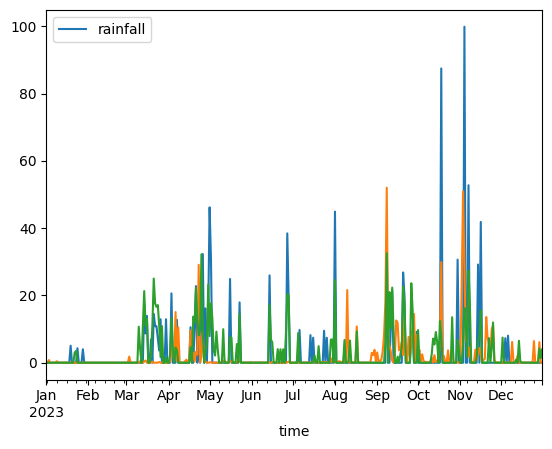

In [ ]:
rainfall_df.plot(x='Date', y='rainfall')
pr_df['TA00026'].plot()

tamsat_t26['rfe'].plot()

## Severe Weather Event Analysis
- Flash floods
- Heatwave

### EM-Data
Global Database for Comprehensive Disaster Data
Over 26,000 records of disasters from 1900 to the present day. <br>
- Data sourced from a diverse organizations: UN agencies, NGOs, insurance companies, research institutes, and press agencies.
- Available in open access for non-commercial use.
- Managed and distributed by the Centre for Research on the Epidemiology of Disasters (CRED) with the support of the United States Agency for International Development (USAID).

In [109]:
# upload em-data
uploaded = files.upload()

Saving public_emdat_custom_request_2025-01-22_7db797d1-e0b7-45b4-b622-637664f4bfc9.xlsx to public_emdat_custom_request_2025-01-22_7db797d1-e0b7-45b4-b622-637664f4bfc9.xlsx


In [110]:
# read the excel file
em_data = pd.read_excel('public_emdat_custom_request_2025-01-22_7db797d1-e0b7-45b4-b622-637664f4bfc9.xlsx')

In [111]:
em_data

DisNo. Historic Classification Key Disaster Group  \
0    2017-0032-MAR       No    nat-met-ext-col        Natural   
1    2017-0033-DZA       No    nat-met-ext-col        Natural   
2    2017-0051-MOZ       No    nat-met-sto-tro        Natural   
3    2017-0054-MAR       No    nat-met-ext-col        Natural   
4    2017-0075-MDG       No    nat-met-sto-tro        Natural   
..             ...      ...                ...            ...   
528  2024-9131-ZMB       No    nat-cli-dro-dro        Natural   
529  2024-9197-MWI       No    nat-cli-dro-dro        Natural   
530  2024-9197-ZWE       No    nat-cli-dro-dro        Natural   
531  2024-9338-NAM       No    nat-cli-dro-dro        Natural   
532  2024-9592-AGO       No    nat-cli-dro-dro        Natural   

    Disaster Subgroup        Disaster Type  Disaster Subtype  \
0      Meteorological  Extreme temperature         Cold wave   
1      Meteorological  Extreme temperature         Cold wave   
2      Meteorological                Storm  Tropical cyclone   
3      Meteorological  Extreme temperature         Cold wave   
4      Meteorological                Storm  Tropical cyclone   
..                ...                  ...               ...   
528    Climatological              Drought           Drought   
529    Climatological              Drought           Drought   
530    Climatological              Drought           Drought   
531    Climatological              Drought           Drought   
532    Climatological              Drought           Drought   

                                  External IDs       Event Name  ISO  ...  \
0                         GLIDE:CW-2017-000008              NaN  MAR  ...   
1                         GLIDE:CL-2017-000011              NaN  DZA  ...   
2                         GLIDE:FL-2017-000012  Cyclone 'Dineo'  MOZ  ...   
3                         GLIDE:CW-2016-000016              NaN  MAR  ...   
4                                          NaN  Cyclone 'Enawo'  MDG  ...   
..                                         ...              ...  ...  ...   
528                       GLIDE:DR-2024-000018              NaN  ZMB  ...   
529  GLIDE:DR-2024-000066|GLIDE:DR-2024-000069              NaN  MWI  ...   
530  GLIDE:DR-2024-000066|GLIDE:DR-2024-000069              NaN  ZWE  ...   
531                       GLIDE:DR-2024-000094              NaN  NAM  ...   
532                       GLIDE:DR-2024-000095              NaN  AGO  ...   

    Reconstruction Costs ('000 US$) Reconstruction Costs, Adjusted ('000 US$)  \
0                               NaN                                       NaN   
1                               NaN                                       NaN   
2                               NaN                                       NaN   
3                               NaN                                       NaN   
4                               NaN                                       NaN   
..                              ...                                       ...   
528                             NaN                                       NaN   
529                             NaN                                       NaN   
530                             NaN                                       NaN   
531                             NaN                                       NaN   
532                             NaN                                       NaN   

    Insured Damage ('000 US$) Insured Damage, Adjusted ('000 US$)  \
0                         NaN                                 NaN   
1                         NaN                                 NaN   
2                         NaN                                 NaN   
3                         NaN                                 NaN   
4                         NaN                                 NaN   
..                        ...                                 ...   
528                       NaN                                 NaN   
529         

In [115]:
em_data.columns

Index(['DisNo.', 'Historic', 'Classification Key', 'Disaster Group',
       'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
       'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region',
       'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal',
       'Declaration', 'AID Contribution ('000 US$)', 'Magnitude',
       'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year',
       'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day',
       'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damage ('000 US$)', 'Insured Damage, Adjusted ('000 US$)',
       'Total Damage ('000 US$)', 'Total Damage, Adjusted ('000 US$)', 'CPI',
       'Admin Units', 'Entry Date', 'Last Update'],
      dtype='object')

In [126]:
em_data[(em_data['Disaster Type'] == 'Flood') & (em_data['Country'] == 'Kenya') & (em_data['Start Year'] == 2023)][['Latitude', 'Longitude']]

Latitude  Longitude
414       NaN        NaN
420       NaN        NaN
443       NaN        NaN

### TAHMO station extreme events based on the 95th percentile

Extreme Rainfall Events:
Date
2023-04-06 00:00:00+00:00    15.062
2023-04-08 00:00:00+00:00    10.472
2023-04-23 00:00:00+00:00    29.104
2023-08-10 00:00:00+00:00    21.602
2023-08-17 00:00:00+00:00    10.782
2023-09-07 00:00:00+00:00    17.995
2023-09-08 00:00:00+00:00    52.018
2023-09-15 00:00:00+00:00    12.559
2023-09-16 00:00:00+00:00    11.722
2023-09-21 00:00:00+00:00    12.723
2023-09-27 00:00:00+00:00    11.135
2023-09-28 00:00:00+00:00    14.474
2023-10-18 00:00:00+00:00    29.922
2023-11-02 00:00:00+00:00    23.245
2023-11-03 00:00:00+00:00    50.914
2023-11-04 00:00:00+00:00    28.824
2023-11-20 00:00:00+00:00    13.594
2023-11-24 00:00:00+00:00     9.953
2023-11-25 00:00:00+00:00    11.077
Name: TA00026, dtype: float64


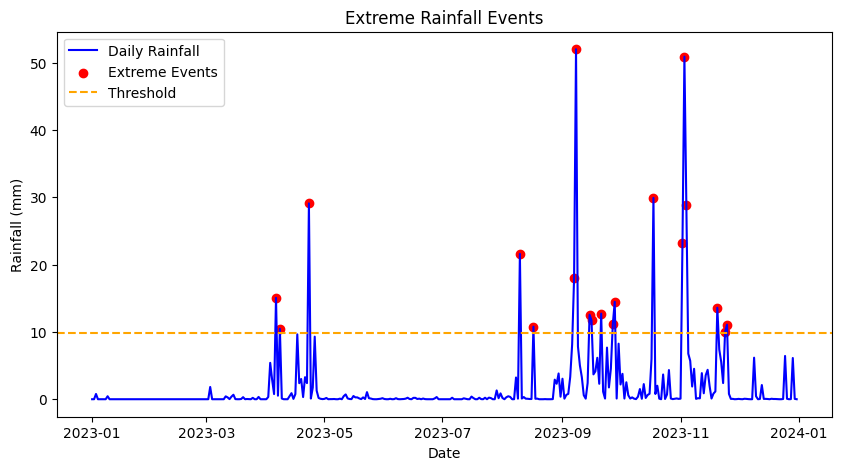

In [18]:
# Set threshold for extreme rainfall (e.g., 95th percentile)
threshold = pr_df[station_name_list[0]].quantile(0.95)

# Identify extreme events
extreme_rainfall_events = pr_df[station_name_list[0]][pr_df[station_name_list[0]]> threshold]
print("Extreme Rainfall Events:")
print(extreme_rainfall_events)

# Highlight extreme events in plot
plt.figure(figsize=(10, 5))
plt.plot(pr_df[station_name_list[0]].index, pr_df[station_name_list[0]], label='Daily Rainfall', color='blue')
plt.scatter(extreme_rainfall_events.index, extreme_rainfall_events, color='red', label='Extreme Events')
plt.axhline(y=threshold, color='orange', linestyle='--', label='Threshold')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Extreme Rainfall Events')
plt.legend()
plt.show()


### Analyze Cumulative Rainfall for Flash Flood Risks

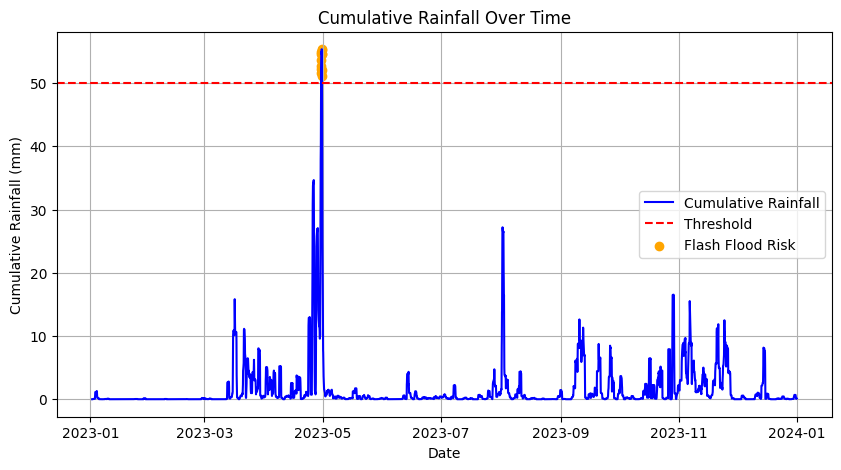

Flash Flood Risk Events:
                     Cumulative_Rainfall
Date                                    
2023-04-30 06:00:00            51.602938
2023-04-30 07:00:00            52.299419
2023-04-30 08:00:00            52.693628
2023-04-30 09:00:00            53.705403
2023-04-30 10:00:00            54.553547
2023-04-30 11:00:00            54.920096
2023-04-30 12:00:00            54.625472
2023-04-30 13:00:00            55.280933
2023-04-30 14:00:00            55.352866
2023-04-30 15:00:00            54.629382
2023-04-30 16:00:00            52.116237
2023-04-30 17:00:00            51.051981


In [71]:
# Define time window for cumulative rainfall (e.g., 24 hours)
window = 24  # in hours

# Calculate cumulative rainfall
era5_df['Cumulative_Rainfall'] = era5_df['total_precipitation'].rolling(window=window).sum()

# Define threshold for flash flood risk
cumulative_rainfall_threshold = 50  # in mm (adjust based on local context)

# Identify periods exceeding threshold
flash_flood_risks = era5_df[era5_df['Cumulative_Rainfall'] > cumulative_rainfall_threshold]

# cumulative rainfall with flash flood risks
plt.figure(figsize=(10, 5))
plt.plot(era5_df.index, era5_df['Cumulative_Rainfall'], label='Cumulative Rainfall', color='blue')
plt.axhline(cumulative_rainfall_threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(flash_flood_risks.index, flash_flood_risks['Cumulative_Rainfall'], color='orange', label='Flash Flood Risk')
plt.title('Cumulative Rainfall Over Time')
plt.ylabel('Cumulative Rainfall (mm)')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

# flash flood risk events
print("Flash Flood Risk Events:")
print(flash_flood_risks[['Cumulative_Rainfall']])


### Koeppen Geiger Climate Classification

In [73]:
# Method to perform Koeppen Geiger Climate Classification System
def koeppen_geiger_classification(lat, long):
    reqUrl = f"http://climateapi.scottpinkelman.com/api/v1/location/{lat}/{long}"
    headersList = {
        "Accept": "*/*",
        "User-Agent": "Thunder Client (https://www.thunderclient.com)"
    }
    payload = ""
    response = requests.request("GET", reqUrl, data=payload, headers=headersList)
    return response.json()['return_values'][0]

koeppen_geiger_classification(-0.287122, 36.169981)['zone_description']

'Marine west coast, warm summer'

In [78]:
stations_metadata[stations_metadata['code'] == 'TA00026'][['code', 'elevationground', 'location.type', 'location.elevationmsl']]

code  elevationground     location.type  location.elevationmsl
24  TA00026              3.0  Secondary school                 1939.9

### Correlating Variables to Predict Floods
Rainfall and Temperature: Positive correlation might indicate rainfall follows an increase in temperature (e.g., convective storms). <br>
Rainfall and Wind Speed: A strong correlation could highlight stormy weather conditions (high wind speed and intense rainfall).<br>
Temperature and Wind Speed: Positive correlation might indicate increased convection.<br>
Key Thresholds:

- |r| > 0.7: Strong correlation.
- 0.3 ≤ |r| ≤ 0.7: Moderate correlation.
- |r| < 0.3: Weak correlation.

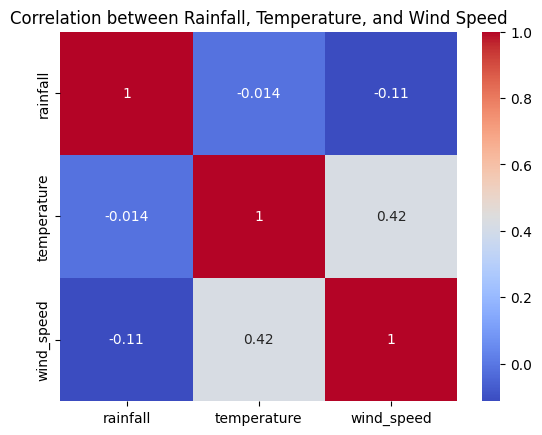

In [85]:
import seaborn as sns
data = pd.DataFrame({
    'rainfall': era5_df['total_precipitation'],  # Rainfall in mm
    'temperature': era5_df['temperature_2m'],   # Temperature in °C
    'wind_speed': era5_df['wind_speed'],        # Wind speed in m/s
})

# Compute correlations
correlation_matrix = data.corr()

# Visualize correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation between Rainfall, Temperature, and Wind Speed')
plt.show()


### Analysis for your region
- Using filter-stations Filter class to input the address and get the lat,lon and from this get the weather data for the region
- Steps to obtaining a Google Maps API

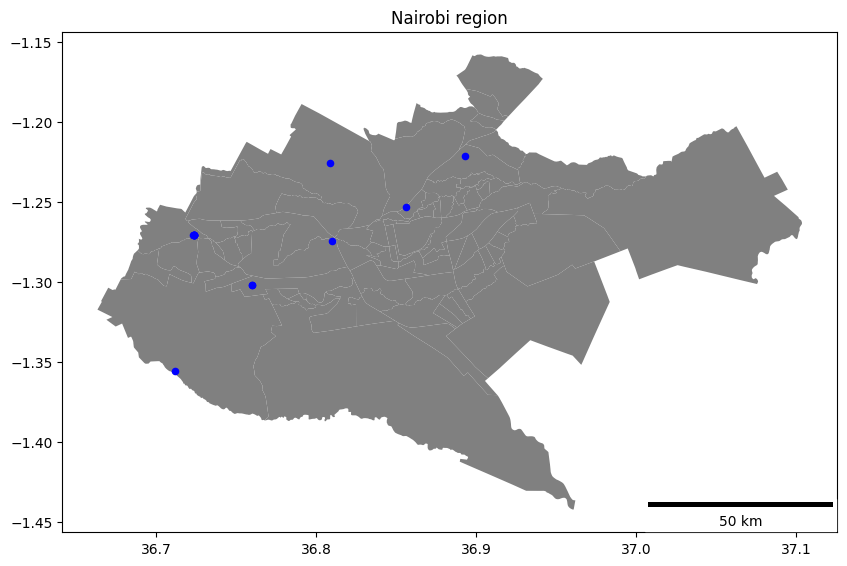

In [93]:
# Get the coordinates for a specific region
nai_lat, nai_lon = fs.centre_point('Nairobi, Kenya')

# Get the weather stations within nairobi region
nai_stations = fs.stations_region('Nairobi')

# Plot the map of the region with the stations
fs.stations_region('Nairobi', plot=True)

### Customized Forecast Models
Integrating ERA5 data to TAHMO data for customised weather forecasting

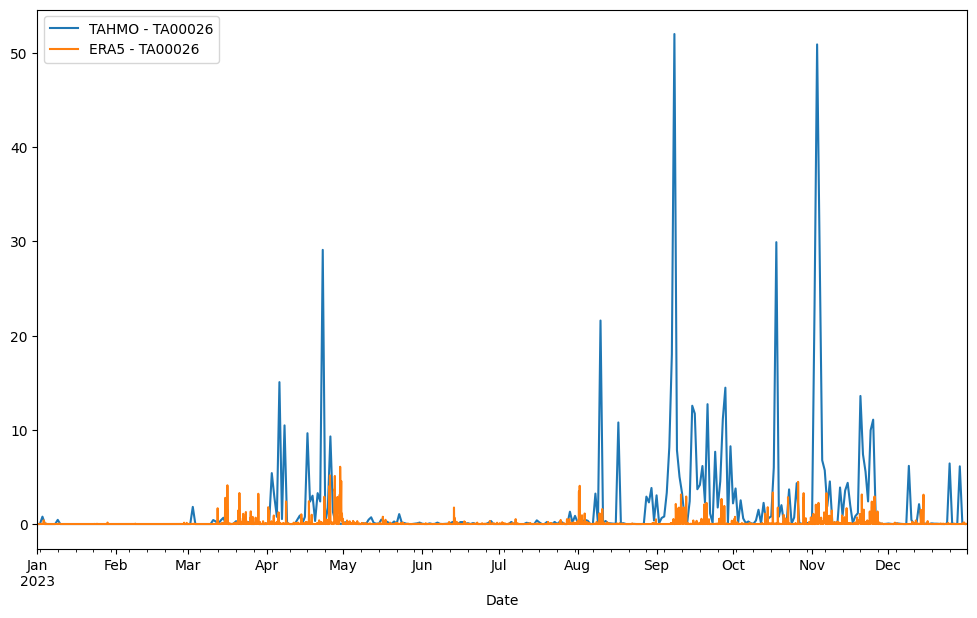

In [94]:
pr_df[station_name_list[0]].plot(figsize=(12,7), label=f'TAHMO - {station_name_list[0]}') # Added label
era5_df['total_precipitation'].plot(figsize=(12,7), label=f'ERA5 - {station_name_list[0]}')
plt.legend()

In [155]:
t_26 = ret.aggregate_variables(pr_df[station_name_list[0]], freq='1D')
t_26.index = t_26.index.tz_localize(None)
t_26.columns = ['precipitation_station']

In [156]:
# Merge station and ERA5 data
df = pd.merge_asof(
    t_26.sort_index(),
    ret.aggregate_variables(era5_df['total_precipitation'], freq='1D').sort_index(),
    on="Date",
    tolerance=pd.Timedelta("1D"),  # Align to nearest hour
    direction="nearest"
)

# Drop missing values after merging
df.dropna(inplace=True)

# Example of combined dataset
print(df.head())


        Date  precipitation_station  total_precipitation
0 2023-01-01                  0.000         3.469447e-15
1 2023-01-02                  0.000         5.905607e-02
2 2023-01-03                  0.782         1.151413e+00
3 2023-01-04                  0.000         2.091071e-01
4 2023-01-05                  0.000         1.026452e-02


In [157]:
df['hour'] = df['Date'].dt.hour
df['dayofyear'] = df['Date'].dt.dayofyear
df['month'] = df['Date'].dt.month


In [158]:
te_26 = ret.aggregate_variables(te_df['TA00026'], method='mean', freq='1D')
te_26.index = te_26.index.tz_localize(None)
te_26.columns = ['temperature_station']

temperature_2m
Date                      
2023-01-01       18.490343
2023-01-02       17.982469
2023-01-03       16.890118
2023-01-04       17.365380
2023-01-05       17.196798
...                    ...
2023-12-27       19.162174
2023-12-28       18.961343
2023-12-29       19.785897
2023-12-30       20.072635
2023-12-31       20.245944

[365 rows x 1 columns]

In [163]:
pr_te_26 = pd.concat([df.set_index('Date'), te_26, ret.aggregate_variables(era5_df['temperature_2m'], method='mean', freq='1D')], axis=1).reset_index()
pr_te_26

Date  precipitation_station  total_precipitation  hour  dayofyear  \
0   2023-01-01                  0.000         3.469447e-15     0          1   
1   2023-01-02                  0.000         5.905607e-02     0          2   
2   2023-01-03                  0.782         1.151413e+00     0          3   
3   2023-01-04                  0.000         2.091071e-01     0          4   
4   2023-01-05                  0.000         1.026452e-02     0          5   
..         ...                    ...                  ...   ...        ...   
360 2023-12-27                  0.000         3.092504e-03     0        361   
361 2023-12-28                  0.017        -1.040834e-14     0        362   
362 2023-12-29                  6.126         4.286697e-02     0        363   
363 2023-12-30                  0.051         6.904794e-01     0        364   
364 2023-12-31                  0.000         1.169075e-01     0        365   

     month  temperature_station  temperature_2m  
0        1            18.389236       18.490343  
1        1            17.302778       17.982469  
2        1            16.203819       16.890118  
3        1            17.975347       17.365380  
4        1            17.830903       17.196798  
..     ...                  ...             ...  
360     12            18.564583       19.162174  
361     12            18.461806       18.961343  
362     12            18.417361       19.785897  
363     12            19.836111       20.072635  
364     12            14.300000       20.245944  

[365 rows x 8 columns]

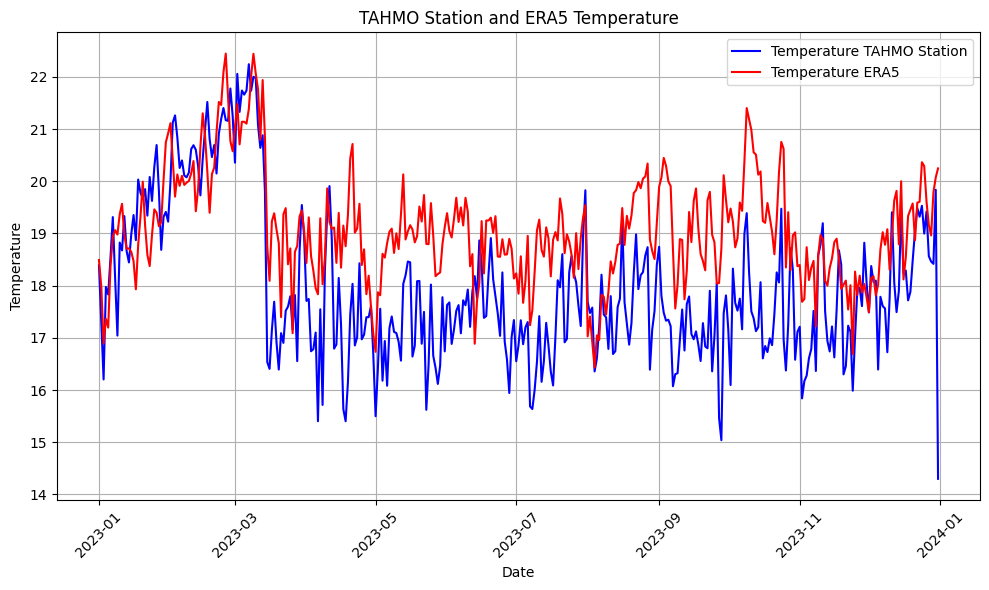

In [168]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(pr_te_26['Date'], pr_te_26['temperature_station'], label='Temperature TAHMO Station', color='blue')
plt.plot(pr_te_26['Date'], pr_te_26['temperature_2m'], label='Temperature ERA5', color='red')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('TAHMO Station and ERA5 Temperature')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.xticks(rotation=45) # Rotate x-axis labels for better visibility

# Show the plot
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [169]:
train = pr_te_26[pr_te_26['Date'] < '2023-10-01']
test = pr_te_26[pr_te_26['Date'] >= '2023-10-01']


In [180]:
from sklearn.ensemble import RandomForestRegressor

# Features and target
features_a = train[['temperature_station', 'precipitation_station', 'hour', 'dayofyear', 'month']]
target_a = train['precipitation_station']  # Replace with 'temperature_station' for temp forecasting

# Train Model A
model_a = RandomForestRegressor()
model_a.fit(features_a, target_a)


RandomForestRegressor()

In [149]:
era5_df.columns

Index(['total_precipitation', 'u_component_of_wind_10m',
       'v_component_of_wind_10m', 'temperature_2m',
       'instantaneous_10m_wind_gust', 'wind_speed', 'wind_direction',
       'Rainfall_MA', 'Cumulative_Rainfall'],
      dtype='object')

In [150]:
train

Date  precipitation_station  total_precipitation  hour  dayofyear  \
0   2023-01-01                  0.000         3.469447e-15     0          1   
1   2023-01-02                  0.000         5.905607e-02     0          2   
2   2023-01-03                  0.782         1.151413e+00     0          3   
3   2023-01-04                  0.000         2.091071e-01     0          4   
4   2023-01-05                  0.000         1.026452e-02     0          5   
..         ...                    ...                  ...   ...        ...   
268 2023-09-26                  4.543         6.554092e+00     0        269   
269 2023-09-27                 11.135         2.900245e+00     0        270   
270 2023-09-28                 14.474         1.631347e-01     0        271   
271 2023-09-29                  0.102        -8.673617e-15     0        272   
272 2023-09-30                  8.255         9.227438e-01     0        273   

     month  temperature_station  
0        1            18.389236  
1        1            17.302778  
2        1            16.203819  
3        1            17.975347  
4        1            17.830903  
..     ...                  ...  
268      9            18.046181  
269      9            15.465625  
270      9            15.039931  
271      9            17.469097  
272      9            17.812847  

[273 rows x 7 columns]

In [148]:
pd.concat([era5_df['']])

In [179]:
# Features and target
features_b = train[['temperature_station', 'precipitation_station',
                    'temperature_2m', 'total_precipitation', 'hour', 'dayofyear', 'month']]
target_b = train['precipitation_station']  # Replace as needed

# Train Model B
model_b = RandomForestRegressor()
model_b.fit(features_b, target_b)


RandomForestRegressor()

In [181]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions
test_a = test[['temperature_station', 'precipitation_station', 'hour', 'dayofyear', 'month']]
test_b = test[['temperature_station', 'precipitation_station',
               'temperature_2m', 'total_precipitation', 'hour', 'dayofyear', 'month']]

pred_a = model_a.predict(test_a)
pred_b = model_b.predict(test_b)

# Evaluation metrics
mae_a = mean_absolute_error(test['precipitation_station'], pred_a)
mae_b = mean_absolute_error(test['precipitation_station'], pred_b)

# Calculate RMSE without the 'squared' argument and using np.sqrt
rmse_a = np.sqrt(mean_squared_error(test['precipitation_station'], pred_a))
rmse_b = np.sqrt(mean_squared_error(test['precipitation_station'], pred_b))

r2_a = r2_score(test['precipitation_station'], pred_a)
r2_b = r2_score(test['precipitation_station'], pred_b)

print(f"Model A - MAE: {mae_a}, RMSE: {rmse_a}, R²: {r2_a}")
print(f"Model B - MAE: {mae_b}, RMSE: {rmse_b}, R²: {r2_b}")

Model A - MAE: 5.7039496739130415, RMSE: 7.0839261884033435, R²: 0.06141136765406219
Model B - MAE: 0.45108336956521705, RMSE: 1.7344397126352664, R²: 0.943734050400942


### Graphcast Modelling
Add current data to graphcast model to get my personalised model for forecasting



In [183]:
!pip install ai-models-graphcast

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.2/345.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.0 MB/s eta 0:00:00
  Created wheel for multiurl: filename=multiurl-0.3.3-py3-none-any.whl size=21230 sha256=5

In [186]:
!pip install ai-models-panguweather
!pip install ai-models-fourcastnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 11.3 MB/s eta 0:00:00
  Created wheel for ai-models-fourcastnet: filename=ai_models_fourcastnet-0.0.7-py3-none-any.whl size=15511 sha256=27bd2f167c8a2a8da92e82661cd7519c5bafd1b771c1d01abce0505502ee4b9a
  Stored in directory: /root/.cache/pip/wheels/33/3c/8e/0c1437bdea8156ae568cc1681e449b3e32665786bc7f8fee6e
Successfully built ai-models-fourcastnet


In [187]:
!pip install ai-models

In [ ]:
!ai-models --download-assets --assets assets-panguweather panguweather
!ai-models --download-assets --assets assets-fourcastnet  fourcastnet
!ai-models --download-assets --assets assets-graphcast    graphcast

2025-01-28 10:24:49,801 INFO Writing results to panguweather.grib
2025-01-28 10:24:49,802 INFO Downloading /content/assets-panguweather/pangu_weather_24.onnx
2025-01-28 10:24:49,802 INFO Downloading https://get.ecmwf.int/repository/test-data/ai-models/pangu-weather/pangu_weather_24.onnx
2025-01-28 10:26:18,092 INFO Downloading /content/assets-panguweather/pangu_weather_6.onnx
2025-01-28 10:26:18,093 INFO Downloading https://get.ecmwf.int/repository/test-data/ai-models/pangu-weather/pangu_weather_6.onnx
pangu_weather_6.onnx:  72% 816M/1.10G [01:05<00:20, 16.0MB/s]

### Panguweather

In [ ]:
!ai-models --input cds --date 20230920 --time 0000 --assets assets-panguweather panguweather
